In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse.linalg import expm_multiply, expm
from scipy.sparse import diags
from utils import *
from ionq_circuit_utils import *

from os import getenv
from os.path import join
import json
import hashlib

import networkx as nx
from random import shuffle, seed

import requests

from braket.circuits import Circuit
from braket.devices import LocalSimulator
from braket.aws import AwsDevice, AwsQuantumTask

from qiskit import QuantumCircuit, transpile

from dotenv import load_dotenv
load_dotenv()

True

In [2]:
IONQ_API_KEY = getenv('IONQ_API_KEY')

# Helper functions

In [3]:
# Sends job and returns job_id
def send_job(job):
    headers = {
        "Authorization": f"apiKey {IONQ_API_KEY}",
        "Content-Type": "application/json"
    }
    req = requests.post("https://api.ionq.co/v0.3/jobs", json=job, headers=headers)
    try:
        job_id = json.loads(req.content)['id']
    except KeyError:
        print(req.content)
        raise KeyError(f"Error sending job. Error message: {req.content['''message''']}")
    return job_id

In [4]:
def get_ionq_single_job_result(job_id, codewords, use_error_mitigation=False):
    # Get job
    print("Getting job:", job_id)

    headers = {
        "Authorization": f"apiKey {IONQ_API_KEY}"
    }

    req = requests.get(f"https://api.ionq.co/v0.3/jobs/{job_id}", headers=headers)
    

    status = json.loads(req.content)['status']
    print(f"Job status: {status}")
    if status == "completed":
        
        headers = {
            "Authorization": f"apiKey {IONQ_API_KEY}"
        }
        if use_error_mitigation:
            params = {"sharpen": "true"} # plural voting aggregation
        else:
            params = {"sharpen": "false"}
        req = requests.get(f"https://api.ionq.co/v0.3/jobs/{job_id}/results", headers=headers, params=params)
        results = json.loads(req.content)
        if "error" in results.keys():
            raise AttributeError(results["message"])
        else:
            freq = np.zeros(len(codewords))
            for i in range(len(codewords)):
                if str(codewords[i]) in results.keys():
                    freq[i] = results[str(codewords[i])]
            return freq
    else:
        raise FileNotFoundError("Job not completed")
    
def get_results(job_ids_path, num_time_points, codewords, use_error_mitigation=False):
    with open(job_ids_path, "r") as f:
        job_ids = json.load(f)
        f.close()

    freq = np.zeros((num_time_points, len(codewords)))
    for i, job_id in enumerate(job_ids):

        freq[i] = get_ionq_single_job_result(job_id, codewords, use_error_mitigation)

    return freq

def cancel_job(job_id):
    print("Cancelling job:", job_id)

    headers = {
        "Authorization": f"apiKey {IONQ_API_KEY}"
    }
    r = requests.put(f"https://api.ionq.co/v0.3/jobs/{job_id}/status/cancel", headers=headers)
    return r

Quantum walk circuit

In [5]:
def get_qw_circuit(graph, t, r):

    # Returns Trotterized circuit for quantum walk on graph using one-hot embedding

    line_graph = nx.line_graph(graph)
    coloring = nx.coloring.greedy_color(line_graph, strategy="independent_set")

    coloring_grouped = {}
    for edge in coloring.keys():
        if coloring[edge] in coloring_grouped:
            coloring_grouped[coloring[edge]].append(edge)
        else:
            coloring_grouped[coloring[edge]] = [edge]

    num_colors = len(coloring_grouped.keys())

    instructions = []

    # Use randomized first order Trotter
    dt = t / r
    
    np.random.seed(int(t * r))
    for _ in range(r):
        if np.random.rand() < 0.5:
            for color in np.arange(0, num_colors):
                edge_list = coloring_grouped[color]
                
                for i,j in edge_list:
                    instructions.append(get_rxx(dt, targets=[int(i),int(j)]))
                    instructions.append(get_ryy(dt, targets=[int(i),int(j)]))
        else:
            for color in np.arange(0, num_colors)[::-1]:
                edge_list = coloring_grouped[color]
                
                for i,j in edge_list:
                    instructions.append(get_ryy(dt, targets=[int(i),int(j)]))
                    instructions.append(get_rxx(dt, targets=[int(i),int(j)]))
    return instructions

Spatial search circuit

In [6]:
def get_spatial_search_circuit(N, lamb, gamma, t, r, encoding, use_second_order_pf=False):
    n = num_qubits_per_dim(N, encoding)
    dimension = 2
    instructions = []

    dt = t / r
    np.random.seed(int(t * r))

    if encoding == "unary" or encoding == "antiferromagnetic":
        instructions += get_hadamard_layer(n, dimension)

        for _ in range(r):
            if use_second_order_pf:
                # X rotations (between hadamard)
                for i in range(dimension * n):
                    instructions.append(get_rz(- gamma * dt, i))

                # penalty term
                for i in range(dimension):
                    instructions.append(get_rx(2 * lamb * dt, i * n))
                    if encoding == "unary":
                        instructions.append(get_rx(-2 * lamb * dt, int((i + 1) * n - 1)))
                    if encoding == "antiferromagnetic":
                        instructions.append(get_rx((-1) ** (n) * 2 * lamb * dt, int((i + 1) * n - 1)))
                    
                    for j in np.arange(i * n, (i + 1) * n - 1):
                        if encoding == "unary":
                            instructions.append(get_rxx(-2 * lamb * dt, [int(j), int(j+1)]))
                        elif encoding == "antiferromagnetic":
                            instructions.append(get_rxx(2 * lamb * dt, [int(j), int(j+1)]))

                # oracle term
                instructions.append(get_rxx(dt / 2, [int(n-1), int(n)]))
                instructions.append(get_rx(dt / 2, n-1))
                instructions.append(get_rx(- dt / 2, n))

                # laplacian correction term
                for i in range(dimension):
                    instructions.append(get_rx(-gamma * dt, i * n))
                    if encoding == "unary":
                        instructions.append(get_rx(gamma * dt, int((i + 1) * n - 1)))
                    elif encoding == "antiferromagnetic":
                        instructions.append(get_rx((-1) ** (n+1) * gamma * dt, int((i + 1) * n - 1)))
                
                # X rotations (between hadamard)
                for i in range(dimension * n):
                    instructions.append(get_rz(- gamma * dt, i))
            else:
                # Use randomized first order
                if np.random.rand() < 0.5:
                    # X rotations (between hadamard)
                    for i in range(dimension * n):
                        instructions.append(get_rz(- 2 * gamma * dt, i))

                    # penalty term
                    for i in range(dimension):
                        instructions.append(get_rx(2 * lamb * dt, i * n))
                        if encoding == "unary":
                            instructions.append(get_rx(-2 * lamb * dt, int((i + 1) * n - 1)))
                        if encoding == "antiferromagnetic":
                            instructions.append(get_rx((-1) ** (n) * 2 * lamb * dt, int((i + 1) * n - 1)))
                        
                        for j in np.arange(i * n, (i + 1) * n - 1):
                            if encoding == "unary":
                                instructions.append(get_rxx(-2 * lamb * dt, [int(j), int(j+1)]))
                            elif encoding == "antiferromagnetic":
                                instructions.append(get_rxx(2 * lamb * dt, [int(j), int(j+1)]))

                    # oracle term
                    instructions.append(get_rxx(dt / 2, [int(n-1), int(n)]))
                    instructions.append(get_rx(dt / 2, n-1))
                    instructions.append(get_rx(- dt / 2, n))

                    # laplacian correction term
                    for i in range(dimension):
                        instructions.append(get_rx(-gamma * dt, i * n))
                        if encoding == "unary":
                            instructions.append(get_rx(gamma * dt, int((i + 1) * n - 1)))
                        elif encoding == "antiferromagnetic":
                            instructions.append(get_rx((-1) ** (n+1) * gamma * dt, int((i + 1) * n - 1)))
                else:
                    # laplacian correction term
                    for i in range(dimension):
                        instructions.append(get_rx(-gamma * dt, i * n))
                        if encoding == "unary":
                            instructions.append(get_rx(gamma * dt, int((i + 1) * n - 1)))
                        elif encoding == "antiferromagnetic":
                            instructions.append(get_rx((-1) ** (n+1) * gamma * dt, int((i + 1) * n - 1)))

                    # oracle term
                    instructions.append(get_rxx(dt / 2, [int(n-1), int(n)]))
                    instructions.append(get_rx(dt / 2, n-1))
                    instructions.append(get_rx(- dt / 2, n))

                    # penalty term
                    for i in range(dimension):
                        instructions.append(get_rx(2 * lamb * dt, i * n))
                        if encoding == "unary":
                            instructions.append(get_rx(-2 * lamb * dt, int((i + 1) * n - 1)))
                        if encoding == "antiferromagnetic":
                            instructions.append(get_rx((-1) ** (n) * 2 * lamb * dt, int((i + 1) * n - 1)))
                        
                        for j in np.arange(i * n, (i + 1) * n - 1)[::-1]:
                            if encoding == "unary":
                                instructions.append(get_rxx(-2 * lamb * dt, [int(j), int(j+1)]))
                            elif encoding == "antiferromagnetic":
                                instructions.append(get_rxx(2 * lamb * dt, [int(j), int(j+1)]))
                                
                    # X rotations (between hadamard)
                    for i in range(dimension * n):
                        instructions.append(get_rz(- 2 * gamma * dt, i))
        
        instructions += get_hadamard_layer(n, dimension)

        return instructions
    elif encoding == "one-hot":
        marked_vertex_index_1 = N-1
        marked_vertex_index_2 = 0
        for _ in range(r):
            if use_second_order_pf:
                # Laplacian term
                for i in range(dimension):
                    for j in np.arange(i * n, (i + 1) * n - 1, 2):
                        instructions.append(get_rxx(- 0.5 * gamma * dt, [int(j), int(j+1)]))
                        instructions.append(get_ryy(- 0.5 * gamma * dt, [int(j), int(j+1)]))
                    for j in np.arange(i * n + 1, (i + 1) * n - 1, 2):
                        instructions.append(get_rxx(- 0.5 * gamma * dt, [int(j), int(j+1)]))
                        instructions.append(get_ryy(- 0.5 * gamma * dt, [int(j), int(j+1)]))
                        
                # Laplacian correction term
                for i in range(dimension):
                    instructions.append(get_rz(gamma * dt, int(i * n)))
                    instructions.append(get_rz(gamma * dt, int((i + 1) * n - 1)))

                # Oracle term
                instructions.append(get_rzz(- dt / 2, [marked_vertex_index_1, n + marked_vertex_index_2]))
                instructions.append(get_rz(dt / 2, marked_vertex_index_1))
                instructions.append(get_rz(dt / 2, n + marked_vertex_index_2))

                # Laplacian term
                for i in range(dimension):
                    for j in np.arange(i * n + 1, (i + 1) * n - 1, 2):
                        instructions.append(get_rxx(- 0.5 * gamma * dt, [int(j), int(j+1)]))
                        instructions.append(get_ryy(- 0.5 * gamma * dt, [int(j), int(j+1)]))
                    for j in np.arange(i * n, (i + 1) * n - 1, 2):
                        instructions.append(get_rxx(- 0.5 * gamma * dt, [int(j), int(j+1)]))
                        instructions.append(get_ryy(- 0.5 * gamma * dt, [int(j), int(j+1)]))
            else:
                if np.random.rand() < 0.5:
                    # Laplacian term
                    for i in range(dimension):
                        for j in np.arange(i * n, (i + 1) * n - 1, 2):
                            instructions.append(get_rxx(- gamma * dt, [int(j), int(j+1)]))
                            instructions.append(get_ryy(- gamma * dt, [int(j), int(j+1)]))
                        for j in np.arange(i * n + 1, (i + 1) * n - 1, 2):
                            instructions.append(get_rxx(- gamma * dt, [int(j), int(j+1)]))
                            instructions.append(get_ryy(- gamma * dt, [int(j), int(j+1)]))
                            
                    # Laplacian correction term
                    for i in range(dimension):
                        instructions.append(get_rz(gamma * dt, int(i * n)))
                        instructions.append(get_rz(gamma * dt, int((i + 1) * n - 1)))

                    # Oracle term
                    instructions.append(get_rzz(- dt / 2, [marked_vertex_index_1, n + marked_vertex_index_2]))
                    instructions.append(get_rz(dt / 2, marked_vertex_index_1))
                    instructions.append(get_rz(dt / 2, n + marked_vertex_index_2))

                else:
                    # Oracle term
                    instructions.append(get_rzz(- dt / 2, [marked_vertex_index_1, n + marked_vertex_index_2]))
                    instructions.append(get_rz(dt / 2, marked_vertex_index_1))
                    instructions.append(get_rz(dt / 2, n + marked_vertex_index_2))

                    # Laplacian correction term
                    for i in range(dimension):
                        instructions.append(get_rz(gamma * dt, int(i * n)))
                        instructions.append(get_rz(gamma * dt, int((i + 1) * n - 1)))

                    # Laplacian term
                    for i in range(dimension):
                        for j in np.arange(i * n + 1, (i + 1) * n - 1, 2):
                            instructions.append(get_rxx(- gamma * dt, [int(j), int(j+1)]))
                            instructions.append(get_ryy(- gamma * dt, [int(j), int(j+1)]))
                        for j in np.arange(i * n, (i + 1) * n - 1, 2):
                            instructions.append(get_rxx(- gamma * dt, [int(j), int(j+1)]))
                            instructions.append(get_ryy(- gamma * dt, [int(j), int(j+1)]))
        
        return instructions
    else:
        raise ValueError("Encoding not supported")

Truncated Fock space method circuit

In [7]:
def get_fock_space_method_circuit(N, a, b, t, r, encoding, use_second_order_pf=False):
    # Real-space Schrodinger equation with potential f(x) = 0.5 * ax^2 + bx

    n = num_qubits_per_dim(N, encoding=encoding)
    dt = t / r
    
    instructions = []

    np.random.seed(int(t * r))

    if encoding == "one-hot":
        if use_second_order_pf:
            for _ in range(r):
                # Diagonal part of 0.5 * \hat{p}^2 and 0.5 * a\hat{x}^2
                for i in range(n):
                    instructions.append(get_rz(-0.25 * (1 + a) * (i + 1/2) * dt, i))

                # Off-diagonal part of 0.5 * \hat{p}^2 and off-diagonal part of 0.5 * a\hat{x} ^ 2
                for i in range(n-2):
                    instructions.append(get_rxx(0.25 * (a * np.sqrt((i + 1) * (i + 2)) - np.sqrt((i + 1) * (i + 2))) * dt, [i, i + 2]))
                    instructions.append(get_ryy(0.25 * (a * np.sqrt((i + 1) * (i + 2)) - np.sqrt((i + 1) * (i + 2))) * dt, [i, i + 2]))
                # b \hat{x}
                for i in range(n-1):
                    instructions.append(get_rxx(b * np.sqrt((i + 1) / 2) * dt, [i, i + 1]))
                    instructions.append(get_ryy(b * np.sqrt((i + 1) / 2) * dt, [i, i + 1]))

                # Diagonal part of 0.5 * \hat{p}^2 and 0.5 * a\hat{x}^2
                for i in range(n):
                    instructions.append(get_rz(-0.25 * (1 + a) * (i + 1/2) * dt, i))
        else:
            for _ in range(r):
                if np.random.rand() < 0.5:
                    # Diagonal part of 0.5 * \hat{p}^2 and 0.5 * a\hat{x}^2
                    for i in range(n):
                        instructions.append(get_rz(-0.5 * (1 + a) * (i + 1/2) * dt, i))

                    # Off-diagonal part of 0.5 * \hat{p}^2 and off-diagonal part of 0.5 * a\hat{x} ^ 2
                    for i in range(n-2):
                        instructions.append(get_rxx(0.25 * (a * np.sqrt((i + 1) * (i + 2)) - np.sqrt((i + 1) * (i + 2))) * dt, [i, i + 2]))
                        instructions.append(get_ryy(0.25 * (a * np.sqrt((i + 1) * (i + 2)) - np.sqrt((i + 1) * (i + 2))) * dt, [i, i + 2]))
                    # b \hat{x}
                    for i in range(n-1):
                        instructions.append(get_rxx(b * np.sqrt((i + 1) / 2) * dt, [i, i + 1]))
                        instructions.append(get_ryy(b * np.sqrt((i + 1) / 2) * dt, [i, i + 1]))
                else:
                    # b \hat{x}
                    for i in range(n-1)[::-1]:
                        instructions.append(get_rxx(b * np.sqrt((i + 1) / 2) * dt, [i, i + 1]))
                        instructions.append(get_ryy(b * np.sqrt((i + 1) / 2) * dt, [i, i + 1]))

                    # Off-diagonal part of 0.5 * \hat{p}^2 and off-diagonal part of 0.5 * a\hat{x} ^ 2
                    for i in range(n-2)[::-1]:
                        instructions.append(get_rxx(0.25 * (a * np.sqrt((i + 1) * (i + 2)) - np.sqrt((i + 1) * (i + 2))) * dt, [i, i + 2]))
                        instructions.append(get_ryy(0.25 * (a * np.sqrt((i + 1) * (i + 2)) - np.sqrt((i + 1) * (i + 2))) * dt, [i, i + 2]))

                    # Diagonal part of 0.5 * \hat{p}^2 and 0.5 * a\hat{x}^2
                    for i in range(n)[::-1]:
                        instructions.append(get_rz(-0.5 * (1 + a) * (i + 1/2) * dt, i))

    else:
        raise ValueError("Encoding not supported")

    return instructions


In [8]:
def run_qw(N, dimension, n, encoding, bitstrings, num_time_points, graph, t_vals, task_name, 
           vertex, r, num_shots, device, save_dir, use_real_machine, qpu_job_ids_filename):
    assert encoding == "one-hot"

    job_ids = []
    task_arns = []

    # unnormalized probabilities
    sim_freq = np.zeros((num_time_points, N))
    dimension = 1

    for i, t in enumerate(t_vals):
        
        print(f"Unitless time: {t : 0.3f}")

        # Construct the circuit
        instructions = []

        # Initial state preparation: start from root node
        instructions.append(get_rx(np.pi, vertex))
        if t > 0:
            instructions += get_qw_circuit(graph, t, r)

        if use_real_machine:

            # Create the job json and save it
            job = get_ionq_job_json(task_name, N, dimension, num_shots, device, encoding, instructions, use_native_gates=True)
            
            print(f"Saving in {save_dir}")
            with open(join(save_dir, f"job_{i}.json"), "w") as f:
                json.dump(job, f, default=int)

            # Send the job and get the job id
            job_id = send_job(job)
            print("Job id:", job_id)
            job_ids.append(job_id)

        else:
            
            native_instructions, qubit_phase = get_native_circuit(n, instructions)
            one_qubit_gate_count, two_qubit_gate_count = get_native_gate_counts(native_instructions)
            print(f"1q gates: {one_qubit_gate_count}, 2q gates: {two_qubit_gate_count}")
            circuit = get_braket_native_circuit(native_instructions)
            for j in range(n * dimension):
                circuit.rz(j, -qubit_phase[j] * (2 * np.pi))

            circuit.amplitude(state=bitstrings)

            # Run on simulator
            task = device.run(circuit)

            if device.name == "SV1":
                # Save the data
                metadata = task.metadata()
                task_arn = metadata['quantumTaskArn']
                task_arns.append(task_arn)
                print(f"ARN: {task_arn}")
            else:
                amplitudes = task.result().values[0]
                for j in range(N ** dimension):
                    sim_freq[i,j] = np.abs(amplitudes[bitstrings[j]]) ** 2

    if use_real_machine:
        print(f"Saving IonQ job ids as {qpu_job_ids_filename}")
        with open(join(save_dir, qpu_job_ids_filename), "w") as f:
            json.dump(job_ids, f)
            f.close()
    else:
        return sim_freq

In [9]:
def run_ss(N, dimension, encoding, bitstrings, num_time_points, t_vals, task_name, 
           gamma, r, num_shots, device, save_dir, use_real_machine, 
           qpu_job_ids_filename, lamb=None, use_second_order_pf=False,
           optimize_circuit=False):
    n = num_qubits_per_dim(N, encoding)

    job_ids = []

    # unnormalized probabilities
    sim_freq = np.zeros((num_time_points, N ** dimension))

    amplitudes_input = np.ones(N)
    amplitudes_input /= np.linalg.norm(amplitudes_input)

    for i, t in enumerate(t_vals):
        
        print(f"Unitless time: {t : 0.3f}")

        # use braket simulator and get amplitudes of state vector
        instructions = state_prep_circuit(N, dimension, amplitudes_input, encoding)
        instructions += get_spatial_search_circuit(N, lamb, gamma, t, r, encoding, use_second_order_pf)
        if optimize_circuit:
            # Optimize with Qiskit
            compiled_circuit = transpile(get_qiskit_circuit(n * dimension, instructions), basis_gates=['rxx', 'rx', 'ry', 'rz'], optimization_level=3)
            instructions = get_circuit_from_qiskit(compiled_circuit)
            
        if use_real_machine:
            
            # Create the job json and save it
            job = get_ionq_job_json(task_name, N, dimension, num_shots, device, encoding, instructions, use_native_gates=True)
            
            print(f"Saving in {save_dir}")
            with open(join(save_dir, f"job_{i}.json"), "w") as f:
                json.dump(job, f, default=int)

            # Send the job and get the job id
            job_id = send_job(job)
            print("Job id:", job_id)
            job_ids.append(job_id)
        else:
            
            native_instructions, qubit_phase = get_native_circuit(dimension * n, instructions)
            one_qubit_gate_count, two_qubit_gate_count = get_native_gate_counts(native_instructions)
            print(f"1q gates: {one_qubit_gate_count}, 2q gates: {two_qubit_gate_count}")
            circuit = get_braket_native_circuit(native_instructions)
            for j in range(n * dimension):
                circuit.rz(j, -qubit_phase[j] * (2 * np.pi))

            circuit.amplitude(state=bitstrings)

            # Run on simulator
            task = device.run(circuit)
            # occurrences = get_occurrences(N, task.result().measurements, num_shots, dimension, encoding, periodic=False)
            # sim_freq[i] = occurrences.flatten() / np.sum(occurrences)

            amplitudes_res = task.result().values[0]
            for j in range(N ** dimension):
                sim_freq[i,j] = np.abs(amplitudes_res[bitstrings[j]]) ** 2

    if use_real_machine:
        print("Saving IonQ job ids")
        with open(join(save_dir, qpu_job_ids_filename), "w") as f:
            json.dump(job_ids, f)
            f.close()
    else:
        return sim_freq

In [10]:
def run_fock_space_method(N, dimension, encoding, num_time_points, t_vals, task_name,
           r, a, b, num_shots_z, num_shots_x, device, save_dir, use_real_machine, use_second_order_pf,
           qpu_job_ids_filename_z, qpu_job_ids_filename_x):

    assert dimension == 1, "Expected dimension is 1"
    assert encoding == "one-hot"
    
    n = num_qubits_per_dim(N, encoding)

    if use_real_machine:
        # Job ids for circuits without Hadamard layer
        job_ids_z = []
        # Job ids for circuits with Hadamard layer
        job_ids_x = []
    else:
        distributions_z = []
        distributions_x = []

    for i, t in enumerate(t_vals):
        
        print(f"Unitless time: {t : 0.3f}")

        # Construct the circuit
        instructions = []

        # Initial state preparation: start from root node
        instructions.append(get_rx(np.pi, 0))
        if t > 0:
            instructions += get_fock_space_method_circuit(N, a, b, t, r, encoding, use_second_order_pf)
        
        # Send the circuits without Hadamard layer
        if use_real_machine:
            
            # Create the job json and save it
            job = get_ionq_job_json(task_name, N, dimension, num_shots_z, device, encoding, instructions, use_native_gates=True)
            
            with open(join(save_dir, f"t_{i}", f"job_z.json"), "w") as f:
                json.dump(job, f, default=int)

            # Send the job and get the job id
            job_id = send_job(job)
            print("Job id:", job_id)
            job_ids_z.append(job_id)
        else:

            native_instructions, qubit_phase = get_native_circuit(n, instructions)
            one_qubit_gate_count, two_qubit_gate_count = get_native_gate_counts(native_instructions)
            print(f"1q gates: {one_qubit_gate_count}, 2q gates: {two_qubit_gate_count}")
            circuit = get_braket_native_circuit(native_instructions)
            for j in range(n * dimension):
                circuit.rz(j, -qubit_phase[j] * (2 * np.pi))

            # Get amplitudes
            bitstrings = [np.binary_repr(j, n)[::-1] for j in range(2 ** n)]
            circuit.amplitude(state=bitstrings)
            
            # Run on simulator
            task = device.run(circuit)
            amplitudes_res = task.result().values[0]
            distributions_z.append(np.abs(list(amplitudes_res.values())) ** 2)

            # dist = np.zeros(2 ** N)
            # for measurement in task.result().measurements:
            #     dist[bitstring_to_int(measurement)] += 1
            # dist /= num_shots_z
            # distributions_z.append(dist)

        # Measure in X basis
        instructions += get_hadamard_layer(n, dimension)

        if use_real_machine:
            
            # Create the job json and save it
            job = get_ionq_job_json(task_name, N, dimension, num_shots_x, device, encoding, instructions)
            
            with open(join(save_dir, f"t_{i}", f"job_x.json"), "w") as f:
                json.dump(job, f, default=int)
            # Send the job and get the job id
            job_id = send_job(job)
            print("Job id:", job_id)
            job_ids_x.append(job_id)

        else:
            native_instructions, qubit_phase = get_native_circuit(n, instructions)
            circuit = get_braket_native_circuit(native_instructions)
            for j in range(n * dimension):
                circuit.rz(j, -qubit_phase[j] * (2 * np.pi))

            # Get amplitudes
            bitstrings = [np.binary_repr(j, n)[::-1] for j in range(2 ** n)]
            circuit.amplitude(state=bitstrings)

            # Run on simulator
            task = device.run(circuit)
            amplitudes_res = task.result().values[0]
            distributions_x.append(np.abs(list(amplitudes_res.values())) ** 2)

            # dist = np.zeros(2 ** N)
            # for measurement in task.result().measurements:
            #     dist[bitstring_to_int(measurement)] += 1
            # dist /= num_shots_x
            # distributions_x.append(dist)

    if use_real_machine:
        print("Saving IonQ job ids")
        with open(join(save_dir, qpu_job_ids_filename_z), "w") as f:
            json.dump(job_ids_z, f)
            f.close()

        with open(join(save_dir, qpu_job_ids_filename_x), "w") as f:
            json.dump(job_ids_x, f)
            f.close()

    if not use_real_machine:
        return distributions_z, distributions_x

In [11]:
def tv_dist(freq_1, freq_2):
    num_time_points = freq_1.shape[0]
    return [np.sum(np.abs(freq_1[i] - freq_2[i])) / 2 for i in range(num_time_points)]

def tv_dist_err(freq_true, freq_sampled, num_samples):
    assert num_samples > 1
    vec = np.zeros(len(freq_true))
    for i in range(len(freq_true)):
        if freq_sampled[i] > 0:
            vec[i] = np.maximum(0, 1 - freq_true[i] / freq_sampled[i])

    # TV distance is vec @ freq_2
    return np.sqrt(freq_sampled @ (vec - 0.5 * np.sum(np.abs(freq_true - freq_sampled))) ** 2 / (num_samples - 1))

# Quantum walk on 1D chain

In [37]:
DATA_DIR = "experiment_data"
TASK_DIR = "1d-chain"

CURR_DIR = DATA_DIR
check_and_make_dir(CURR_DIR)
CURR_DIR = join(CURR_DIR, TASK_DIR)
check_and_make_dir(CURR_DIR)

print(CURR_DIR)

use_real_machine = False
if use_real_machine:
    device = "qpu.aria-1"
    # device = "simulator"
    print("Device:", device)
else:
    device = LocalSimulator()

    # device = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/sv1")

    print(f"Using {device.name}")

experiment_data/1d-chain
Using StateVectorSimulator


In [38]:
N = 15
r = 5

# N = 9
# r = 10

dimension = 1
encoding = "one-hot"
n = num_qubits_per_dim(N, encoding)
codewords = get_codewords_1d(n, encoding, periodic=False)
bitstrings = get_bitstrings(N, dimension, encoding)
T = 4.0
num_time_points = 17
t_vals = np.linspace(0, T, num_time_points)

# Trotter steps
num_shots = 200
vertex = int(N/2)

use_error_mitigation = False

if use_error_mitigation:
    assert num_shots >= 500, "Number of shots should be at least 500"

experiment_info = {
    "N": N,
    "dimension": dimension,
    "encoding": encoding,
    "T": T,
    "num_time_points": num_time_points,
    "r": r,
    "num_shots": num_shots,
    "vertex": vertex,
    "use_error_mitigation": use_error_mitigation
}

hash_str = hashlib.md5(json.dumps(experiment_info).encode("utf-8")).hexdigest()
SAVE_DIR = join(CURR_DIR, hash_str)
check_and_make_dir(SAVE_DIR)

print("Save dir:", SAVE_DIR)

with open(join(SAVE_DIR, "experiment_info.json"), "w") as f:
    json.dump(experiment_info, f)
    f.close()

graph = nx.path_graph(N)

A = nx.adjacency_matrix(graph, nodelist=sorted(graph.nodes()))

print("Two qubit gate count:", graph.size() * 2 * r)

qpu_job_ids_filename = 'job_ids_qpu.json'

Save dir: experiment_data/1d-chain/ac6ac47a3ff98e8024c4443b44abebcb
Two qubit gate count: 140


Submit tasks

In [178]:
if use_real_machine:
    run_qw(N, dimension, n, encoding, bitstrings, num_time_points, graph, t_vals, TASK_DIR, vertex, r, num_shots, device, SAVE_DIR, use_real_machine, qpu_job_ids_filename)
else:
    sim_freq = run_qw(N, dimension, n, encoding, bitstrings, num_time_points, graph, t_vals, TASK_DIR, vertex, r, num_shots, device, SAVE_DIR, use_real_machine, qpu_job_ids_filename)

Unitless time:  0.000
One qubit gates: 1
Two qubit gates: 0
Unitless time:  0.250
One qubit gates: 1
Two qubit gates: 140
Unitless time:  0.500
One qubit gates: 1
Two qubit gates: 140
Unitless time:  0.750
One qubit gates: 1
Two qubit gates: 140
Unitless time:  1.000
One qubit gates: 1
Two qubit gates: 140
Unitless time:  1.250
One qubit gates: 1
Two qubit gates: 140
Unitless time:  1.500
One qubit gates: 1
Two qubit gates: 140
Unitless time:  1.750
One qubit gates: 1
Two qubit gates: 140
Unitless time:  2.000
One qubit gates: 1
Two qubit gates: 140
Unitless time:  2.250
One qubit gates: 1
Two qubit gates: 140
Unitless time:  2.500
One qubit gates: 1
Two qubit gates: 140
Unitless time:  2.750
One qubit gates: 1
Two qubit gates: 140
Unitless time:  3.000
One qubit gates: 1
Two qubit gates: 140
Unitless time:  3.250
One qubit gates: 1
Two qubit gates: 140
Unitless time:  3.500
One qubit gates: 1
Two qubit gates: 140
Unitless time:  3.750
One qubit gates: 1
Two qubit gates: 140
Unitless t

Get tasks

In [179]:
ionq_freq = get_results(join(SAVE_DIR, qpu_job_ids_filename), num_time_points, codewords, use_error_mitigation)

Getting job: 2aa1a5e9-abff-467b-a788-b62c96d4ffe2


Job status: completed
Getting job: f2c64bd7-1c10-4ace-a5a7-5450da8b58f9
Job status: completed
Getting job: 84e3ac3e-d598-4305-819a-e7a7eef554ec
Job status: completed
Getting job: c9ed9fff-0de7-4b54-8faa-e3b0ce56579d
Job status: completed
Getting job: 68258272-c640-4be7-a6ab-40963605e861
Job status: completed
Getting job: 801c3496-8692-4147-8700-50b2c1016543
Job status: completed
Getting job: 1ef9277d-3315-4a4d-bfad-6475972ffb8d
Job status: completed
Getting job: 01c2ebd9-9993-4d48-a9e6-de071d29aa4f
Job status: completed
Getting job: cf826650-73da-4c92-87bc-b6a334fcc7a0
Job status: completed
Getting job: 5494dbd9-bf57-4232-8909-aa9299c7bbf7
Job status: completed
Getting job: ad6f7a49-05d2-469f-a41b-2201359a80ba
Job status: completed
Getting job: 92653594-2af9-499a-833d-69d4993841bc
Job status: completed
Getting job: bf900549-3817-435c-bbbf-fa6fe40cacce
Job status: completed
Getting job: 207b4514-2d78-45f4-b5ea-6816c8d42cab
Job status: completed
Getting job: e84cc35d-a790-4a2b-bd6b-a2f37

Post processing and figures

In [180]:
sim_freq_normalized = np.zeros_like(sim_freq)
for i in range(num_time_points):
    if np.sum(sim_freq[i]) > 0:
        sim_freq_normalized[i] = sim_freq[i] / np.sum(sim_freq[i])

ionq_freq_normalized = np.zeros_like(ionq_freq)
for i in range(num_time_points):
    if np.sum(ionq_freq[i]) > 0:
        ionq_freq_normalized[i] = ionq_freq[i] / np.sum(ionq_freq[i])

num_samples_subspace_ionq = np.sum(ionq_freq, axis=1) * num_shots

In [181]:
# Ground truth
psi_0 = np.zeros(N)
psi_0[vertex] = 1

psi = expm_multiply(-1j * A, psi_0, start=0, stop=T, num=num_time_points)
ideal_dist = np.abs(psi) ** 2

distance_vec = np.abs(np.arange(-int(N/2), int((N+1)/2)))

# Compute propagation distance
propagation_distance_ideal = ideal_dist @ distance_vec
propagation_distance_sim = sim_freq_normalized @ distance_vec
propagation_distance_ionq = ionq_freq_normalized @ distance_vec

# Using unbiased sample variance to compute standard error
propagation_distance_ionq_err = np.array(
    [np.sqrt(ionq_freq_normalized[i] @ (distance_vec - propagation_distance_ionq[i]) ** 2 / (num_samples_subspace_ionq[i] - 1)) for i in range(num_time_points)]
)

valid_points_ionq = np.sum(ionq_freq, axis=1) > 0

In [182]:
np.savez(join(SAVE_DIR, "data.npz"), 
         ideal_dist=ideal_dist,                                         # Ideal QW
         sim_freq=sim_freq,                                             # Simulator with Hamiltonian embedding
         ionq_freq_normalized=ionq_freq_normalized,                     # IonQ (normalized)
         propagation_distance_ideal=propagation_distance_ideal,         # Propagation distance
         propagation_distance_sim=propagation_distance_sim,
         propagation_distance_ionq=propagation_distance_ionq,
         propagation_distance_ionq_err=propagation_distance_ionq_err,   # Propagation distance std error
         ionq_freq=ionq_freq,                                           # IonQ frequency (unnormalized)
         num_samples_subspace_ionq=num_samples_subspace_ionq)           # Samples in encoding subspace

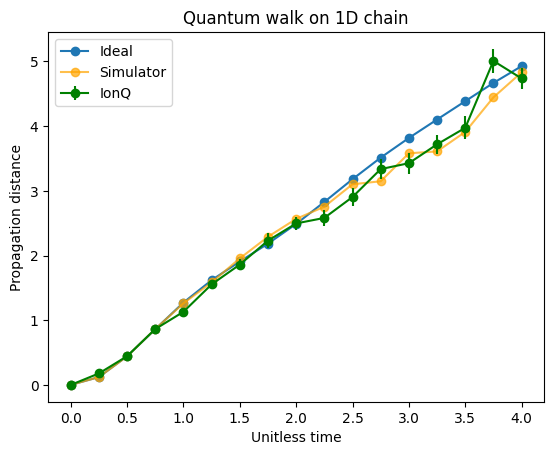

In [183]:
plt.plot(t_vals, propagation_distance_ideal, '-o', label="Ideal")
plt.plot(t_vals, propagation_distance_sim, '-o', label="Simulator", alpha=0.7, color="orange")
plt.errorbar(t_vals[valid_points_ionq], propagation_distance_ionq[valid_points_ionq], propagation_distance_ionq_err, fmt='-o', label="IonQ", color="green")
plt.xlabel("Unitless time")
plt.ylabel("Propagation distance")
plt.title("Quantum walk on 1D chain")
plt.legend()
plt.show()

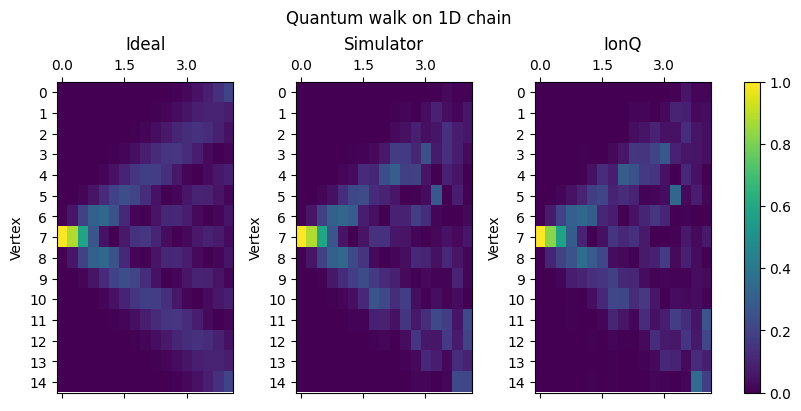

In [168]:
labels = ["Ideal", "Simulator", "IonQ"]

fig, axs = plt.subplots(1, len(labels), constrained_layout=True, facecolor="white", figsize=(8,4))

max_prob = max(np.max(ideal_dist), np.max(sim_freq_normalized))#, np.max(ionq_freq_normalized))
im = axs[0].matshow(ideal_dist.T, vmin=0, vmax=max_prob)
axs[1].matshow(sim_freq_normalized.T, vmin=0, vmax=max_prob)
axs[2].matshow(ionq_freq_normalized.T, vmin=0, vmax=max_prob)

aspect = 2

for i in range(len(labels)):
    axs[i].set_aspect(aspect)
    
    axs[i].set_ylabel("Vertex")
    axs[i].set_yticks(np.arange(ideal_dist.shape[1])[::1])
    axs[i].set_yticklabels(np.arange(ideal_dist.shape[1])[::1])
    axs[i].set_title(labels[i])

    axs[i].set_xticks(np.arange(ideal_dist.shape[0])[::6])
    axs[i].set_xticklabels([str(round(float(label), 3)) for label in t_vals[::6]])

fig.colorbar(im, ax=axs.ravel().tolist())
fig.suptitle("Quantum walk on 1D chain")
plt.show()

# Quantum walk on 1D cycle

In [39]:
DATA_DIR = "experiment_data"
TASK_DIR = "1d-cycle"

CURR_DIR = DATA_DIR
check_and_make_dir(CURR_DIR)
CURR_DIR = join(CURR_DIR, TASK_DIR)
check_and_make_dir(CURR_DIR)

print(CURR_DIR)

use_real_machine = False
if use_real_machine:
    device = "qpu.aria-1"
    # device = "simulator"
    print("Device:", device)
else:
    device = LocalSimulator()

    # device = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/sv1")

    print(f"Using {device.name}")

experiment_data/1d-cycle
Using StateVectorSimulator


In [40]:
N = 15
r = 5

# N = 9
# r = 10
dimension = 1
encoding = "one-hot"
n = num_qubits_per_dim(N, encoding)
codewords = get_codewords_1d(n, encoding, periodic=False)
bitstrings = get_bitstrings(N, dimension, encoding)
T = 4.0
num_time_points = 17
t_vals = np.linspace(0, T, num_time_points)

# Trotter steps
num_shots = 200
vertex = int(N/2)

use_error_mitigation = False

if use_error_mitigation:
    assert num_shots >= 500, "Number of shots should be at least 500"

experiment_info = {
    "N": N,
    "dimension": dimension,
    "encoding": encoding,
    "T": T,
    "num_time_points": num_time_points,
    "r": r,
    "num_shots": num_shots,
    "vertex": vertex,
    "use_error_mitigation": use_error_mitigation
}

hash_str = hashlib.md5(json.dumps(experiment_info).encode("utf-8")).hexdigest()
SAVE_DIR = join(CURR_DIR, hash_str)
check_and_make_dir(SAVE_DIR)

print("Save dir:", SAVE_DIR)

with open(join(SAVE_DIR, "experiment_info.json"), "w") as f:
    json.dump(experiment_info, f)
    f.close()

graph = nx.cycle_graph(N)

A = nx.adjacency_matrix(graph, nodelist=sorted(graph.nodes()))

print("Two qubit gate count:", graph.size() * 2 * r)

qpu_job_ids_filename = 'job_ids_qpu.json'

Save dir: experiment_data/1d-cycle/ac6ac47a3ff98e8024c4443b44abebcb
Two qubit gate count: 150


In [41]:
if use_real_machine:
    run_qw(N, dimension, n, encoding, bitstrings, num_time_points, graph, t_vals, TASK_DIR, vertex, r, num_shots, device, SAVE_DIR, use_real_machine, qpu_job_ids_filename)
else:
    sim_freq = run_qw(N, dimension, n, encoding, bitstrings, num_time_points, graph, t_vals, TASK_DIR, vertex, r, num_shots, device, SAVE_DIR, use_real_machine, qpu_job_ids_filename)

Unitless time:  0.000
One qubit gates: 1
Two qubit gates: 0
Unitless time:  0.250
One qubit gates: 1
Two qubit gates: 150
Unitless time:  0.500
One qubit gates: 1
Two qubit gates: 150
Unitless time:  0.750
One qubit gates: 1
Two qubit gates: 150
Unitless time:  1.000
One qubit gates: 1
Two qubit gates: 150
Unitless time:  1.250
One qubit gates: 1
Two qubit gates: 150
Unitless time:  1.500
One qubit gates: 1
Two qubit gates: 150
Unitless time:  1.750
One qubit gates: 1
Two qubit gates: 150
Unitless time:  2.000
One qubit gates: 1
Two qubit gates: 150
Unitless time:  2.250
One qubit gates: 1
Two qubit gates: 150
Unitless time:  2.500
One qubit gates: 1
Two qubit gates: 150
Unitless time:  2.750
One qubit gates: 1
Two qubit gates: 150
Unitless time:  3.000
One qubit gates: 1
Two qubit gates: 150
Unitless time:  3.250
One qubit gates: 1
Two qubit gates: 150
Unitless time:  3.500
One qubit gates: 1
Two qubit gates: 150
Unitless time:  3.750
One qubit gates: 1
Two qubit gates: 150
Unitless t

Get tasks

In [15]:
ionq_freq = get_results(join(SAVE_DIR, qpu_job_ids_filename), num_time_points, codewords, use_error_mitigation)

Getting job: 53e6b715-f139-4fe7-9c34-34303703d1b5
Job status: completed
Getting job: c6a745ed-3eda-4bdb-9bdd-05cd31ed1c7c
Job status: completed
Getting job: 6478acdc-3a00-4cd5-b271-0199a80b6415
Job status: completed
Getting job: facac175-b619-4f6b-a4f9-3b32b12ac09f
Job status: completed
Getting job: ca59de93-1ffa-4f6c-a078-e34bfed8141c
Job status: completed
Getting job: e8cf70b4-f143-459c-ac86-1ed09392380a
Job status: completed
Getting job: 624f0f3e-c703-4512-9f56-447a11ebccd7
Job status: completed
Getting job: 345b8e83-6949-4c82-96f9-5d58d1b626ba
Job status: completed
Getting job: f64b8d1c-5569-49e5-b155-39b31fcc210e
Job status: completed
Getting job: 58e40c29-322d-4574-8d58-7ac165b9262d
Job status: completed
Getting job: 31e47f44-28b3-4ecc-b78d-897546735acb
Job status: completed
Getting job: a1522eb4-0a6e-4b7c-8bc6-54dc1e2cc4b5
Job status: completed
Getting job: 8e32c1dc-14fb-4958-8ab4-3b52fa03a7b3
Job status: completed
Getting job: 6c6bf2ef-68d6-414c-adfa-3900710e3bce
Job status: co

Figures and post processing

In [16]:
sim_freq_normalized = np.zeros_like(sim_freq)
for i in range(num_time_points):
    if np.sum(sim_freq[i]) > 0:
        sim_freq_normalized[i] = sim_freq[i] / np.sum(sim_freq[i])

ionq_freq_normalized = np.zeros_like(ionq_freq)
for i in range(num_time_points):
    if np.sum(ionq_freq[i]) > 0:
        ionq_freq_normalized[i] = ionq_freq[i] / np.sum(ionq_freq[i])

num_samples_subspace_ionq = np.sum(ionq_freq, axis=1) * num_shots

In [17]:
# Ground truth
psi_0 = np.zeros(N)
psi_0[vertex] = 1

psi = expm_multiply(-1j * A, psi_0, start=0, stop=T, num=num_time_points)
ideal_dist = np.abs(psi) ** 2

distance_vec = np.abs(np.arange(-int(N/2), int((N+1)/2)))

# Compute propagation distance
propagation_distance_ideal = ideal_dist @ distance_vec
propagation_distance_sim = sim_freq_normalized @ distance_vec
propagation_distance_ionq = ionq_freq_normalized @ distance_vec

# Using unbiased sample variance to compute standard error
propagation_distance_ionq_err = np.array(
    [np.sqrt(ionq_freq_normalized[i] @ (distance_vec - propagation_distance_ionq[i]) ** 2 / (num_samples_subspace_ionq[i] - 1)) for i in range(num_time_points)]
)

valid_points_ionq = np.sum(ionq_freq, axis=1) > 0

In [18]:
np.savez(join(SAVE_DIR, "data.npz"), 
         ideal_dist=ideal_dist,                                         # Ideal QW
         sim_freq=sim_freq,                                             # Simulator with Hamiltonian embedding
         ionq_freq_normalized=ionq_freq_normalized,                     # IonQ (normalized)
         propagation_distance_ideal=propagation_distance_ideal,         # Propagation distance
         propagation_distance_sim=propagation_distance_sim,
         propagation_distance_ionq=propagation_distance_ionq,
         propagation_distance_ionq_err=propagation_distance_ionq_err,   # Propagation distance std error
         ionq_freq=ionq_freq,                                           # IonQ frequency (unnormalized)
         num_samples_subspace_ionq=num_samples_subspace_ionq)           # Samples in encoding subspace

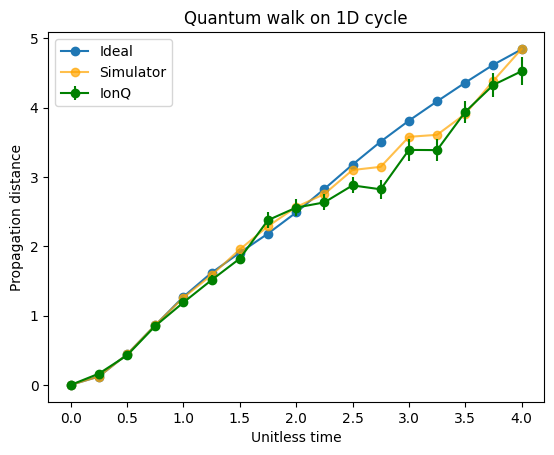

In [20]:
plt.plot(t_vals, propagation_distance_ideal, '-o', label="Ideal")
plt.plot(t_vals, propagation_distance_sim, '-o', label="Simulator", alpha=0.7, color="orange")
plt.errorbar(t_vals[valid_points_ionq], propagation_distance_ionq[valid_points_ionq], propagation_distance_ionq_err, fmt='-o', label="IonQ", color="green")
plt.xlabel("Unitless time")
plt.ylabel("Propagation distance")
plt.title("Quantum walk on 1D cycle")
plt.legend()
plt.show()

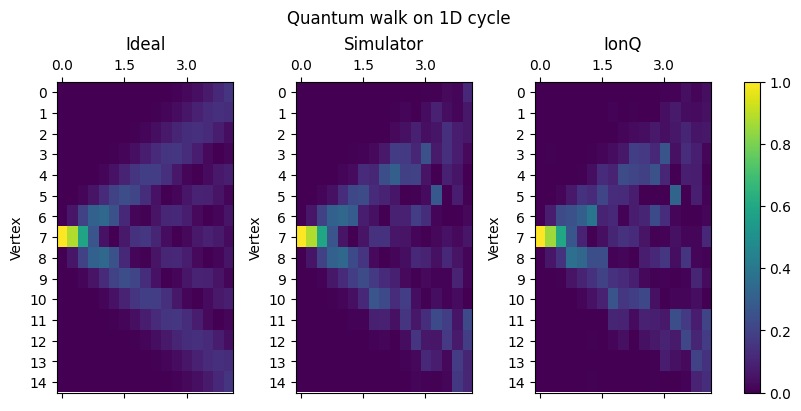

In [21]:
labels = ["Ideal", "Simulator", "IonQ"]

fig, axs = plt.subplots(1, len(labels), constrained_layout=True, facecolor="white", figsize=(8,4))

max_prob = max(np.max(ideal_dist), np.max(sim_freq_normalized), np.max(ionq_freq_normalized))
im = axs[0].matshow(ideal_dist.T, vmin=0, vmax=max_prob)
axs[1].matshow(sim_freq_normalized.T, vmin=0, vmax=max_prob)
axs[2].matshow(ionq_freq_normalized.T, vmin=0, vmax=max_prob)

aspect = 2

for i in range(len(labels)):
    axs[i].set_aspect(aspect)
    
    axs[i].set_ylabel("Vertex")
    axs[i].set_yticks(np.arange(ideal_dist.shape[1])[::1])
    axs[i].set_yticklabels(np.arange(ideal_dist.shape[1])[::1])
    axs[i].set_title(labels[i])

    axs[i].set_xticks(np.arange(ideal_dist.shape[0])[::6])
    axs[i].set_xticklabels([str(round(float(label), 3)) for label in t_vals[::6]])

fig.colorbar(im, ax=axs.ravel().tolist())
fig.suptitle("Quantum walk on 1D cycle")
plt.show()

# Quantum walk on binary tree

In [ ]:
def get_binary_tree(N):
    graph = nx.Graph()
    for i in np.arange(1, N):
        graph.add_edge(int((i-1)/2), int(i))
    return graph

In [3]:
DATA_DIR = "experiment_data"
TASK_DIR = "binary_tree"

CURR_DIR = DATA_DIR
check_and_make_dir(CURR_DIR)
CURR_DIR = join(CURR_DIR, TASK_DIR)
check_and_make_dir(CURR_DIR)

print(CURR_DIR)

use_real_machine = False
if use_real_machine:
    device = "qpu.aria-1"
    print("Device:", device)
else:
    device = LocalSimulator()

    # device = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/sv1")

    print(f"Using {device.name}")

experiment_data/binary_tree
Using StateVectorSimulator


In [4]:
N = 15
dimension = 1
encoding = "one-hot"
n = num_qubits_per_dim(N, encoding)
codewords = get_codewords_1d(n, encoding, periodic=False)
bitstrings = get_bitstrings(N, dimension, encoding)
T = 3.0
num_time_points = 16
t_vals = np.linspace(0, T, num_time_points)

# Trotter steps
r = 6
num_shots = 200
vertex = 0

use_error_mitigation = False

if use_error_mitigation:
    assert num_shots >= 500, "Number of shots should be at least 500"

experiment_info = {
    "N": N,
    "dimension": dimension,
    "encoding": encoding,
    "T": T,
    "num_time_points": num_time_points,
    "r": r,
    "num_shots": num_shots,
    "vertex": vertex,
    "use_error_mitigation": use_error_mitigation
}

hash_str = hashlib.md5(json.dumps(experiment_info).encode("utf-8")).hexdigest()
SAVE_DIR = join(CURR_DIR, hash_str)
check_and_make_dir(SAVE_DIR)

print("Save dir:", SAVE_DIR)

with open(join(SAVE_DIR, "experiment_info.json"), "w") as f:
    json.dump(experiment_info, f)
    f.close()

    
# Create binary tree with N nodes
graph = get_binary_tree(N)

A = nx.adjacency_matrix(graph, nodelist=sorted(graph.nodes()))

print("Two qubit gate count:", graph.size() * 2 * r)

qpu_job_ids_filename = "job_ids_qpu.json"

Save dir: experiment_data/binary_tree/e0a9d7946ebe26ca3eb627428c129933
Two qubit gate count: 168


Submit tasks

In [14]:
if use_real_machine:
    run_qw(N, dimension, n, encoding, bitstrings, num_time_points, graph, t_vals, TASK_DIR, vertex, r, num_shots, device, SAVE_DIR, use_real_machine, qpu_job_ids_filename)
else:
    sim_freq = run_qw(N, dimension, n, encoding, bitstrings, num_time_points, graph, t_vals, TASK_DIR, vertex, r, num_shots, device, SAVE_DIR, use_real_machine, qpu_job_ids_filename)

Unitless time:  0.000
One qubit gates: 1
Two qubit gates: 0
Unitless time:  0.200
One qubit gates: 1
Two qubit gates: 168
Unitless time:  0.400
One qubit gates: 1
Two qubit gates: 168
Unitless time:  0.600
One qubit gates: 1
Two qubit gates: 168
Unitless time:  0.800
One qubit gates: 1
Two qubit gates: 168
Unitless time:  1.000
One qubit gates: 1
Two qubit gates: 168
Unitless time:  1.200
One qubit gates: 1
Two qubit gates: 168
Unitless time:  1.400
One qubit gates: 1
Two qubit gates: 168
Unitless time:  1.600
One qubit gates: 1
Two qubit gates: 168
Unitless time:  1.800
One qubit gates: 1
Two qubit gates: 168
Unitless time:  2.000
One qubit gates: 1
Two qubit gates: 168
Unitless time:  2.200
One qubit gates: 1
Two qubit gates: 168
Unitless time:  2.400
One qubit gates: 1
Two qubit gates: 168
Unitless time:  2.600
One qubit gates: 1
Two qubit gates: 168
Unitless time:  2.800
One qubit gates: 1
Two qubit gates: 168
Unitless time:  3.000
One qubit gates: 1
Two qubit gates: 168


In [15]:
ionq_freq = get_results(join(SAVE_DIR, qpu_job_ids_filename), num_time_points, codewords, use_error_mitigation)

Getting job: 26d74489-1d6d-4945-beff-35f67da1b0e4
Job status: completed
Getting job: dec79db2-d0c6-439c-bac8-ae0b866c358b
Job status: completed
Getting job: c8d95553-b17a-4dc3-bcda-eecc65fb18f2
Job status: completed
Getting job: 0cca04d5-0506-4a43-a6e4-502baf5d549b
Job status: completed
Getting job: 06a70ed3-2fe4-4f3f-83b1-1ccf2ff51032
Job status: completed
Getting job: fc200d81-8baf-4d6d-8d21-1f30fd58301c
Job status: completed
Getting job: 01be974c-4119-4038-a3e6-502f15c99b46
Job status: completed
Getting job: 3e9e688e-0d98-4047-9f14-b0ee69558ee8
Job status: completed
Getting job: 5af64e1f-7e43-46f3-bb23-b0201f9bfeac
Job status: completed
Getting job: 4705e6d7-0f5d-42f6-aa02-dda7a2dc6b8e
Job status: completed
Getting job: 02a51ec9-b33c-4744-aa6f-6bf851863fb4
Job status: completed
Getting job: fe36a0f6-7fe3-45ac-bcb9-be0405324df5
Job status: completed
Getting job: dde81c00-59b1-4b81-8c46-6e9980b1e76c
Job status: completed
Getting job: 86bb0449-d45f-4296-a863-fc21176c7c99
Job status: co

Post processing and figures

In [17]:
sim_freq_normalized = np.zeros_like(sim_freq)
for i in range(num_time_points):
    if np.sum(sim_freq[i]) > 0:
        sim_freq_normalized[i] = sim_freq[i] / np.sum(sim_freq[i])

ionq_freq_normalized = np.zeros_like(ionq_freq)
for i in range(num_time_points):
    if np.sum(ionq_freq[i]) > 0:
        ionq_freq_normalized[i] = ionq_freq[i] / np.sum(ionq_freq[i])

num_samples_subspace_ionq = np.sum(ionq_freq, axis=1) * num_shots

In [24]:
# Ground truth
psi_0 = np.zeros(N)
psi_0[vertex] = 1

psi = expm_multiply(-1j * A, psi_0, start=0, stop=T, num=num_time_points)
ideal_dist = np.abs(psi) ** 2

distance_vec = np.zeros(N)
for i in range(N):
    distance_vec[i] = int(np.log2(i + 1))

# Compute propagation distance
propagation_distance_ideal = ideal_dist @ distance_vec
propagation_distance_sim = sim_freq_normalized @ distance_vec
propagation_distance_ionq = ionq_freq_normalized @ distance_vec

# Using unbiased sample variance
propagation_distance_ionq_err = np.array(
    [np.sqrt(ionq_freq_normalized[i] @ (distance_vec - propagation_distance_ionq[i]) ** 2 / (num_samples_subspace_ionq[i] - 1)) for i in range(num_time_points)]
)

valid_points_ionq = np.sum(ionq_freq, axis=1) > 0

In [29]:
np.savez(join(SAVE_DIR, "data.npz"), 
         ideal_dist=ideal_dist,                                         # Ideal QW
         sim_freq=sim_freq,                                             # Simulator with Hamiltonian embedding
         ionq_freq_normalized=ionq_freq_normalized,                     # IonQ (normalized)
         propagation_distance_ideal=propagation_distance_ideal,         # Propagation distance
         propagation_distance_sim=propagation_distance_sim,
         propagation_distance_ionq=propagation_distance_ionq,
         propagation_distance_ionq_err=propagation_distance_ionq_err,   # Propagation distance std error
         ionq_freq=ionq_freq,                                           # IonQ frequency (unnormalized)
         num_samples_subspace_ionq=num_samples_subspace_ionq)           # Samples in encoding subspace

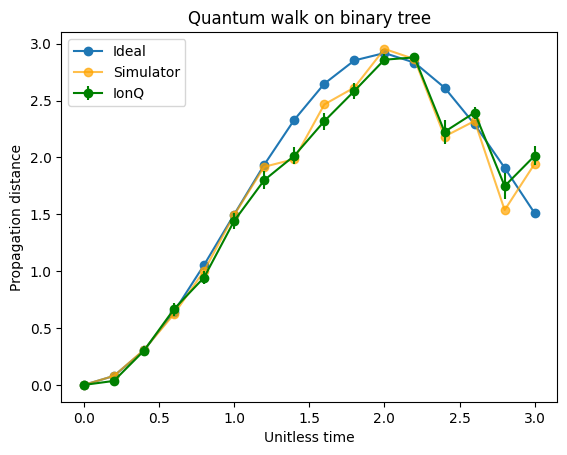

In [25]:
plt.plot(t_vals, propagation_distance_ideal, '-o', label="Ideal")
plt.plot(t_vals, propagation_distance_sim, '-o', label="Simulator", alpha=0.7, color="orange")
plt.errorbar(t_vals[valid_points_ionq], propagation_distance_ionq[valid_points_ionq], propagation_distance_ionq_err, fmt='-o', label="IonQ", color="green")
plt.xlabel("Unitless time")
plt.ylabel("Propagation distance")
plt.title("Quantum walk on binary tree")
plt.legend()
plt.show()

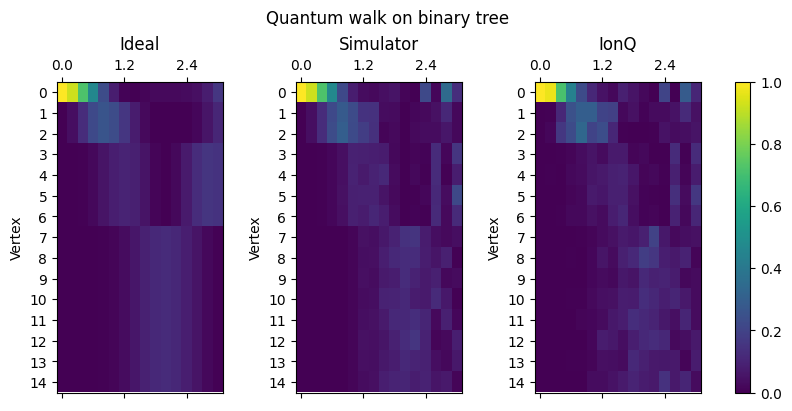

In [26]:
labels = ["Ideal", "Simulator", "IonQ"]

fig, axs = plt.subplots(1, len(labels), constrained_layout=True, facecolor="white", figsize=(8,4))

max_prob = max(np.max(ideal_dist), np.max(sim_freq_normalized), np.max(ionq_freq_normalized))
im = axs[0].matshow(ideal_dist.T, vmin=0, vmax=max_prob)
axs[1].matshow(sim_freq_normalized.T, vmin=0, vmax=max_prob)
axs[2].matshow(ionq_freq_normalized.T, vmin=0, vmax=max_prob)

aspect = 2

for i in range(len(labels)):
    axs[i].set_aspect(aspect)
    
    axs[i].set_ylabel("Vertex")
    axs[i].set_yticks(np.arange(ideal_dist.shape[1])[::1])
    axs[i].set_yticklabels(np.arange(ideal_dist.shape[1])[::1])
    axs[i].set_title(labels[i])

    axs[i].set_xticks(np.arange(ideal_dist.shape[0])[::6])
    axs[i].set_xticklabels([str(round(float(label), 3)) for label in t_vals[::6]])

fig.colorbar(im, ax=axs.ravel().tolist())
fig.suptitle("Quantum walk on binary tree")
plt.show()

# Quantum walk on glued trees graph

In [18]:
DATA_DIR = "experiment_data"
TASK_DIR = "glued_trees"

CURR_DIR = DATA_DIR
check_and_make_dir(CURR_DIR)
CURR_DIR = join(CURR_DIR, TASK_DIR)
check_and_make_dir(CURR_DIR)

print(CURR_DIR)

use_real_machine = False
if use_real_machine:
    device = "qpu.aria-1"
    print("Device:", device)
else:
    device = LocalSimulator()

    # device = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/sv1")

    print(f"Using {device.name}")

experiment_data/glued_trees
Using StateVectorSimulator


In [19]:
def get_glued_tree(h):
    seed(0)
    # Two binary trees of height h (2^(h+1) - 1 nodes each glued together
    num_nodes_per_binary_tree = 2 ** (h+1) - 1
    num_nodes = 2 * num_nodes_per_binary_tree
    graph = nx.Graph()

    # Leaves
    leaves_first = []
    leaves_second = []
    for i in range(2 ** h):
        leaves_first.append(2 ** h - 1 + i)
        leaves_second.append(num_nodes - 1 - (2 ** h - 1) - i)

    for i in np.arange(1, num_nodes_per_binary_tree):

        # First binary tree
        graph.add_edge(int((i-1)/2), int(i))

        # Second binary tree
        graph.add_edge(int(num_nodes - 1 - int((i-1)/2)), int(num_nodes - 1 - i))

    # Glue the two trees together
    # Shuffle the leaves to get a random cycle
    shuffle(leaves_first)
    shuffle(leaves_second)

    for i in range(2 ** h):
        graph.add_edge(int(leaves_first[i]), int(leaves_second[i]))
        graph.add_edge(int(leaves_second[i]), int(leaves_first[(i+1) % (2 ** h)]))

    return graph

Nodes in graph: 14
Save dir: experiment_data/glued_trees/13244c8969e07b1e120ed8b653b294d0
Two qubit gate count: 120


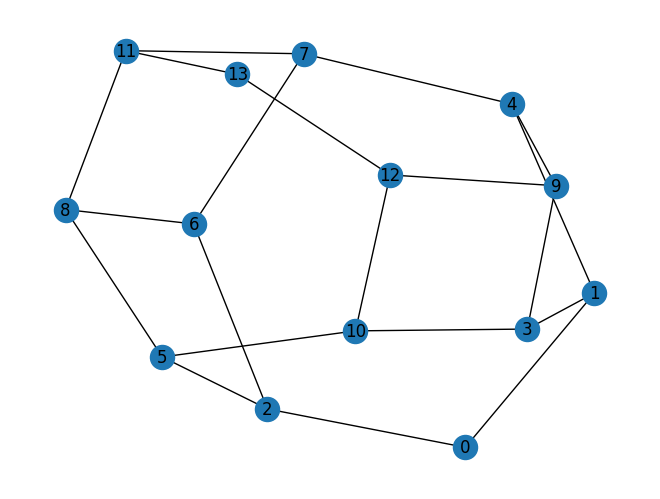

In [20]:
glued_tree_height = 2
N = 2 * (2 ** (glued_tree_height + 1) - 1)
print(f"Nodes in graph: {N}")

dimension = 1
encoding = "one-hot"
n = num_qubits_per_dim(N, encoding=encoding)
codewords = get_codewords_1d(n, encoding, periodic=False)
bitstrings = get_bitstrings(N, dimension, encoding)

T = 2
r = 3

num_time_points = 11
t_vals = np.linspace(0, T, num_time_points)

num_shots = 200
vertex = 0

use_error_mitigation = False

if use_error_mitigation:
    assert num_shots >= 500, "Number of shots should be at least 500"

experiment_info = {
    "N": N,
    "dimension": dimension,
    "encoding": encoding,
    "T": T,
    "num_time_points": num_time_points,
    "r": r,
    "num_shots": num_shots,
    "vertex": vertex,
    "use_error_mitigation": use_error_mitigation,
}

hash_str = hashlib.md5(json.dumps(experiment_info).encode("utf-8")).hexdigest()
SAVE_DIR = join(CURR_DIR, hash_str)
check_and_make_dir(SAVE_DIR)
print("Save dir:", SAVE_DIR)

with open(join(SAVE_DIR, "experiment_info.json"), "w") as f:
    json.dump(experiment_info, f)
    f.close()
    
graph = get_glued_tree(glued_tree_height)

nx.draw(graph, with_labels=True)
A = nx.adjacency_matrix(graph, nodelist=sorted(graph.nodes()))

print("Two qubit gate count:", graph.size() * r * 2)

qpu_job_ids_filename = 'job_ids_qpu.json'

Gate count

In [21]:
# Construct the circuit
instructions = []

# Initial state preparation: start from root node
instructions.append(get_rx(np.pi, vertex))
instructions += get_qw_circuit(graph, T, r)
native_instructions, qubit_phase = get_native_circuit(n, instructions)

one_qubit_gate_count, two_qubit_gate_count = get_native_gate_counts(native_instructions)
print(f"1q gates: {one_qubit_gate_count}, 2q gates: {two_qubit_gate_count}")

1q gates: 1, 2q gates: 120


Submit tasks

In [22]:
if use_real_machine:
    run_qw(N, dimension, n, encoding, bitstrings, num_time_points, graph, t_vals, TASK_DIR, vertex, r, num_shots, device, SAVE_DIR, use_real_machine, qpu_job_ids_filename)
else:
    sim_freq = run_qw(N, dimension, n, encoding, bitstrings, num_time_points, graph, t_vals, TASK_DIR, vertex, r, num_shots, device, SAVE_DIR, use_real_machine, qpu_job_ids_filename)

Unitless time:  0.000
1q gates: 1, 2q gates: 0
Unitless time:  0.200
1q gates: 1, 2q gates: 120
Unitless time:  0.400
1q gates: 1, 2q gates: 120
Unitless time:  0.600
1q gates: 1, 2q gates: 120
Unitless time:  0.800
1q gates: 1, 2q gates: 120
Unitless time:  1.000
1q gates: 1, 2q gates: 120
Unitless time:  1.200
1q gates: 1, 2q gates: 120
Unitless time:  1.400
1q gates: 1, 2q gates: 120
Unitless time:  1.600
1q gates: 1, 2q gates: 120
Unitless time:  1.800
1q gates: 1, 2q gates: 120
Unitless time:  2.000
1q gates: 1, 2q gates: 120


Get data from completed tasks

In [43]:
ionq_freq = get_results(join(SAVE_DIR, qpu_job_ids_filename), num_time_points, codewords, use_error_mitigation)

Getting job: cdb76027-ae66-49ad-8edc-6cc30eba77fc
Job status: completed
Getting job: 4114a50d-28b4-43c1-a1fc-749f4c75b279
Job status: completed
Getting job: 74c57de3-d721-48f9-9108-eba89f8968ad
Job status: completed
Getting job: ad20df45-7c1e-4093-a62f-a42858015210
Job status: completed
Getting job: d391685d-705b-4303-afd7-1986c9bfe702
Job status: completed
Getting job: e55b6408-a856-46a1-94ee-36ef83b8dd24
Job status: completed
Getting job: c85cd818-dbcf-49af-8978-a58fa6a7c04c
Job status: completed
Getting job: b7c8e345-46c3-4065-9901-d285deef598e
Job status: completed
Getting job: 8b2e52a1-867d-420b-87c1-33df057ffca3
Job status: completed
Getting job: 88ebde0c-44d8-4dfc-88ae-f09212a16524
Job status: completed
Getting job: 36135da5-5937-405e-b08d-36932682e987
Job status: completed


Post processing and figures

In [44]:
ionq_freq_normalized = np.zeros_like(ionq_freq)
for i in range(num_time_points):
    if np.sum(ionq_freq[i]) > 0:
        ionq_freq_normalized[i] = ionq_freq[i] / np.sum(ionq_freq[i])

num_samples_subspace_ionq = np.sum(ionq_freq, axis=1) * num_shots

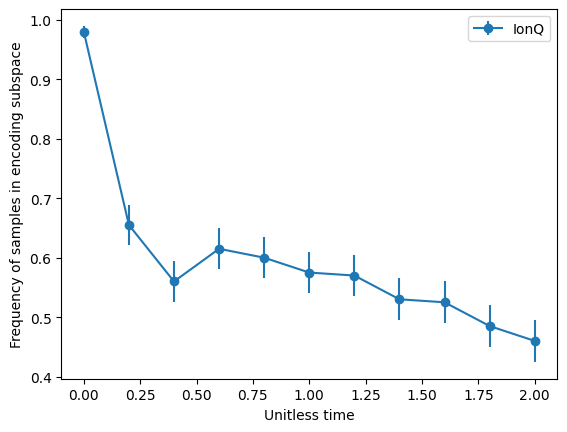

In [45]:
plt.errorbar(t_vals, np.sum(ionq_freq, axis=1), np.sqrt(np.sum(ionq_freq, axis=1) * (1 - np.sum(ionq_freq, axis=1)) / (num_shots - 1)), fmt='-o', label="IonQ")
plt.legend()
plt.ylabel("Frequency of samples in encoding subspace")
plt.xlabel("Unitless time")
plt.show()

In [30]:
# Ground truth
psi_0 = np.zeros(N)
psi_0[vertex] = 1

psi = expm_multiply(-1j * A, psi_0, start=0, stop=T, num=num_time_points)
ideal_dist = np.abs(psi) ** 2

def get_glued_tree_distance_vec(glued_tree_height):
    
    distance_vec = np.zeros(N)
    for i in range(2 ** (glued_tree_height + 1) - 1):
        distance_vec[i] = int(np.log2(i + 1))
    for i in np.arange(2 ** (glued_tree_height + 1) - 1, N):
        distance_vec[i] = 2 * (glued_tree_height + 1) - 1 - int(np.log2(N - i))

    return distance_vec

distance_vec = get_glued_tree_distance_vec(glued_tree_height)

# Compute propagation distance
propagation_distance_ideal = ideal_dist @ distance_vec
propagation_distance_sim = sim_freq @ distance_vec
# propagation_distance_ionq = ionq_freq_normalized @ distance_vec

# # Using unbiased sample variance to compute standard error
# propagation_distance_ionq_err = np.array(
#     [np.sqrt(ionq_freq_normalized[i] @ (distance_vec - propagation_distance_ionq[i]) ** 2 / (num_samples_subspace_ionq[i] - 1)) for i in range(num_time_points)]
# )


# valid_points_ionq = np.sum(ionq_freq, axis=1) > 0


In [47]:
# np.savez(join(SAVE_DIR, "data.npz"), 
#          ideal_dist=ideal_dist,
#          sim_freq=sim_freq,
#          ionq_freq=ionq_freq,
#          ionq_freq_normalized=ionq_freq_normalized,
#          num_samples_subspace_ionq=num_samples_subspace_ionq)

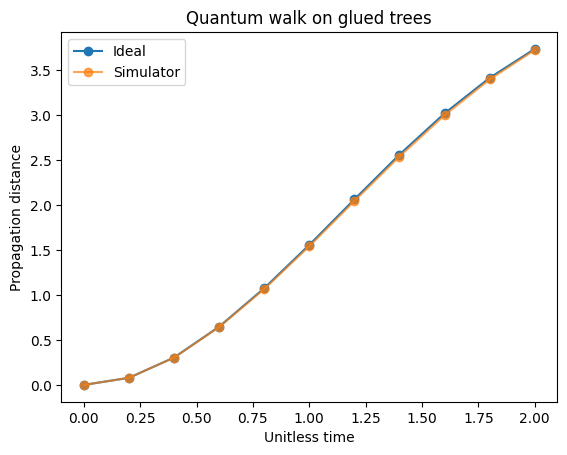

In [31]:
plt.plot(t_vals, propagation_distance_ideal, '-o', label="Ideal")
plt.plot(t_vals, propagation_distance_sim, '-o', label="Simulator", alpha=0.7)
# plt.errorbar(t_vals, propagation_distance_ionq, propagation_distance_ionq_err, fmt='-o', label="IonQ")
plt.xlabel("Unitless time")
plt.ylabel("Propagation distance")
plt.title("Quantum walk on glued trees")
plt.legend()
plt.show()

In [26]:
distance_mat = np.zeros((2 * (glued_tree_height + 1), N))
for i in range(N):
    distance_mat[int(distance_vec[i]), i] = 1

In [130]:
ideal_dist_by_level = ideal_dist @ distance_mat.T
sim_freq_by_level = sim_freq @ distance_mat.T
ionq_dist_by_level = ionq_freq_normalized @ distance_mat.T

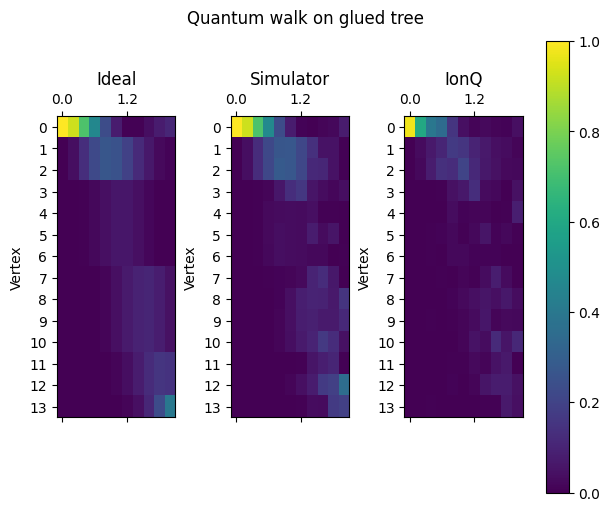

In [132]:

labels = ["Ideal", "Simulator", "IonQ"]

fig, axs = plt.subplots(1, len(labels), constrained_layout=True, facecolor="white", figsize=(6,5))

max_prob = max(np.max(ideal_dist), np.max(sim_freq))#, np.max(ionq_freq))
im = axs[0].matshow(ideal_dist.T, vmin=0, vmax=max_prob)
axs[1].matshow(sim_freq.T, vmin=0, vmax=max_prob)
axs[2].matshow(ionq_freq.T, vmin=0, vmax=
               max_prob)

aspect = 2

for i in range(len(labels)):
    axs[i].set_aspect(aspect)
    
    axs[i].set_ylabel("Vertex")
    axs[i].set_yticks(np.arange(ideal_dist.shape[1])[::1])
    axs[i].set_yticklabels(np.arange(ideal_dist.shape[1])[::1])
    axs[i].set_title(labels[i])

    axs[i].set_xticks(np.arange(ideal_dist.shape[0])[::6])
    axs[i].set_xticklabels([str(round(float(label), 3)) for label in t_vals[::6]])

fig.colorbar(im, ax=axs.ravel().tolist())
fig.suptitle("Quantum walk on glued tree")
plt.savefig(join("figures", f"glued_tree_heatmap_{n}_qubits.png"), facecolor="white", bbox_inches='tight')
plt.show()

# Spatial search

In [19]:
DATA_DIR = "experiment_data"
TASK_DIR = "spatial_search"

CURR_DIR = DATA_DIR
check_and_make_dir(CURR_DIR)
CURR_DIR = join(CURR_DIR, TASK_DIR)
check_and_make_dir(CURR_DIR)

print(CURR_DIR)

use_real_machine = False
if use_real_machine:
    device = "qpu.aria-1"
    print("Device:", device)
else:
    device = LocalSimulator()
    print(f"Using {device.name}")

experiment_data/spatial_search
Using StateVectorSimulator


In [55]:
N = 4
encoding = "unary"
r = 12
lamb = 2

# N = 4
# encoding = "one-hot"
# r = 6
# lamb = None

# N = 5
# encoding = "one-hot"
# r = 5
# lamb = None

dimension = 2
n = num_qubits_per_dim(N, encoding)
codewords = get_codewords(N, dimension, encoding, periodic=False)
bitstrings = get_bitstrings(N, dimension, encoding)

num_time_points = 13
num_shots = 200

def get_T_2d(N, gamma, H_spatial_search):
    dimension = 2
    T = N ** dimension
    num_time_points = 256
    t_vals = np.linspace(0, T, num_time_points)
    p = 4 * (np.log(N) / N) ** 2
    psi_0 = np.ones(N ** dimension)
    psi_0 /= np.linalg.norm(psi_0)

    psi = expm_multiply(-1j * H_spatial_search, psi_0, start=0, stop=T, num=num_time_points)
    dist = np.abs(psi) ** 2

    return t_vals[np.argmax(dist[:,-N] >= p)]

# Compute the optimal gamma
L = get_laplacian_lattice(N, dimension)
marked_vertex_1 = np.zeros(N)
marked_vertex_1[0] = 1
marked_vertex_2 = np.zeros(N)
marked_vertex_2[N-1] = 1

marked_vertex = np.kron(marked_vertex_2, marked_vertex_1)
H_oracle = -csc_matrix(np.outer(marked_vertex, marked_vertex))
# Sign is flipped here; this function minimizes the difference between the two largest eigenvalues of gamma * L + H_oracle
gamma = scipy_get_optimal_gamma(L, -H_oracle, 0.3)
print(f"gamma = {gamma}")
H_spatial_search = - gamma * L + H_oracle
T = get_T_2d(N, gamma, H_spatial_search)
print(f"T = {T : 0.2f}")
t_vals = np.linspace(0, T, num_time_points)

if encoding == "unary":
    optimize_circuit = True
else:
    optimize_circuit = False
    
use_error_mitigation = False
# Second order PF generally seems to give better results than randomized first order Trotter
use_second_order_pf = True

if use_error_mitigation:
    assert num_shots >= 500, "Number of shots should be at least 500"
if not encoding == "one-hot":
    assert lamb is not None
    
if encoding == "one-hot":
    experiment_info = {
        "N": N,
        "dimension": dimension,
        "encoding": encoding,
        "T": T,
        "num_time_points": num_time_points,
        "r": r,
        "num_shots": num_shots,
        "optimize_circuit": optimize_circuit,
        "use_error_mitigation": use_error_mitigation,
        "use_second_order_pf": use_second_order_pf
    }
else:
    experiment_info = {
        "N": N,
        "dimension": dimension,
        "encoding": encoding,
        "T": T,
        "num_time_points": num_time_points,
        "lamb": lamb,
        "r": r,
        "num_shots": num_shots,
        "optimize_circuit": optimize_circuit,
        "use_error_mitigation": use_error_mitigation,
        "use_second_order_pf": use_second_order_pf
    }

hash_str = hashlib.md5(json.dumps(experiment_info).encode("utf-8")).hexdigest()
SAVE_DIR = join(CURR_DIR, hash_str)
check_and_make_dir(SAVE_DIR)

print("Save dir:", SAVE_DIR)

with open(join(SAVE_DIR, "experiment_info.json"), "w") as f:
    json.dump(experiment_info, f)
    f.close()

name = "spatial_search"
qpu_job_ids_filename = f'job_ids_qpu.json'

gamma = 0.6958948087692262
T =  4.89
Save dir: experiment_data/spatial_search/4e3fccdd6b03b435e09538d514913395


In [56]:
amplitudes_input = np.ones(N)
amplitudes_input /= np.linalg.norm(amplitudes_input)
instructions = state_prep_circuit(N, dimension, amplitudes_input, encoding)
instructions += get_spatial_search_circuit(N, lamb, gamma, T, r, encoding, use_second_order_pf)

if optimize_circuit:
    # Optimize with Qiskit
    compiled_circuit = transpile(get_qiskit_circuit(n * dimension, instructions), basis_gates=['rxx', 'rx', 'ry', 'rz'], optimization_level=3)
    instructions = get_circuit_from_qiskit(compiled_circuit)

job = get_ionq_job_json("", N, dimension, num_shots, device, encoding, instructions, use_native_gates=True)

One qubit gates: 132
Two qubit gates: 114


Submit tasks

In [57]:
if use_real_machine:
    run_ss(N, dimension, encoding, bitstrings, num_time_points, t_vals, TASK_DIR, 
           gamma, r, num_shots, device, SAVE_DIR, use_real_machine, 
           qpu_job_ids_filename, lamb=lamb, use_second_order_pf=use_second_order_pf,
           optimize_circuit=optimize_circuit)
else:
    sim_freq = run_ss(N, dimension, encoding, bitstrings, num_time_points, t_vals, TASK_DIR, 
           gamma, r, num_shots, device, SAVE_DIR, use_real_machine, 
           qpu_job_ids_filename, lamb=lamb, use_second_order_pf=use_second_order_pf,
           optimize_circuit=optimize_circuit)
    print(np.sum(sim_freq, axis=1))

Unitless time:  0.000
One qubit gates: 40
Two qubit gates: 8
Unitless time:  0.408
One qubit gates: 132
Two qubit gates: 66
Unitless time:  0.816
One qubit gates: 132
Two qubit gates: 66
Unitless time:  1.224
One qubit gates: 132
Two qubit gates: 66
Unitless time:  1.631
One qubit gates: 132
Two qubit gates: 66
Unitless time:  2.039
One qubit gates: 132
Two qubit gates: 66
Unitless time:  2.447
One qubit gates: 132
Two qubit gates: 66
Unitless time:  2.855
One qubit gates: 132
Two qubit gates: 66
Unitless time:  3.263
One qubit gates: 132
Two qubit gates: 66
Unitless time:  3.671
One qubit gates: 132
Two qubit gates: 66
Unitless time:  4.078
One qubit gates: 132
Two qubit gates: 66
Unitless time:  4.486
One qubit gates: 132
Two qubit gates: 66
Unitless time:  4.894
One qubit gates: 132
Two qubit gates: 114
[1.         0.85881821 0.97930512 0.90093087 0.94418067 0.95048079
 0.93628789 0.97759904 0.95763156 0.99016434 0.98322408 0.99775016
 0.99758826]


Get data from completed tasks

In [58]:
ionq_freq = get_results(join(SAVE_DIR, qpu_job_ids_filename), num_time_points, codewords, use_error_mitigation=False)
print(np.sum(ionq_freq, axis=1))

Getting job: 1b4f7445-e452-49a1-a94d-6ab02aab89ed
Job status: completed
Getting job: db85d4c3-693f-4e8d-a0b5-ca3240c628e6
Job status: completed
Getting job: ed755aa0-3fb1-4909-a5d7-893ab0323ad7
Job status: completed
Getting job: 3eb8dabe-e6dd-49fe-850f-8f8704be5b53
Job status: completed
Getting job: dd954c1a-b50e-4236-89e5-abcb70f70cbf
Job status: completed
Getting job: 7452ccf2-9a68-4aa3-9b23-dd2082cbb1fa
Job status: completed
Getting job: 2752d316-fca0-4b6e-ba09-56f0d917735f
Job status: completed
Getting job: 0cc0c2e1-2040-4f9f-83f0-8bd0055f96eb
Job status: completed
Getting job: 3d40e7c7-d51a-40f7-9a31-3778b9121426
Job status: completed
Getting job: ce35e86f-8950-410d-b2b6-b476d25a1f55
Job status: completed
Getting job: c8a89cef-fad4-4429-a00a-69ac07f25a13
Job status: completed
Getting job: 3961c346-e724-4840-a472-291e133fbfeb
Job status: completed
Getting job: ac1558c3-e356-49bc-bff2-c366553e2789
Job status: completed
[0.96  0.665 0.82  0.75  0.8   0.7   0.565 0.59  0.68  0.76  0.7

Post processing and figures

In [59]:
# Ideal
psi_0 = np.ones(N ** dimension, dtype=np.complex64)
psi_0 /= np.linalg.norm(psi_0)

H = -gamma * L + H_oracle
num_time_points_ideal = num_time_points
psi = expm_multiply(-1j * H, psi_0, start=0, stop=T, num=num_time_points_ideal)
ideal_dist = np.abs(psi) ** 2
ideal_success_probability = ideal_dist[:, N ** dimension - N]

In [60]:
sim_freq_normalized = np.zeros_like(sim_freq)
for i in range(num_time_points):
    if np.sum(sim_freq[i]) > 0:
        sim_freq_normalized[i] = sim_freq[i] / np.sum(sim_freq[i])

ionq_freq_normalized = np.zeros_like(ionq_freq)
for i in range(num_time_points):
    if np.sum(ionq_freq[i]) > 0:
        ionq_freq_normalized[i] = ionq_freq[i] / np.sum(ionq_freq[i])

num_samples_subspace_ionq = np.sum(ionq_freq, axis=1) * num_shots

valid_points_sim = np.sum(sim_freq, axis=1) > 0
valid_points_ionq = num_samples_subspace_ionq > 0

success_prob_sim = sim_freq_normalized[:,-N]
success_prob_ionq = ionq_freq_normalized[:,-N]
err_ionq = np.sqrt(success_prob_ionq * (1 - success_prob_ionq) / (num_samples_subspace_ionq - 1))


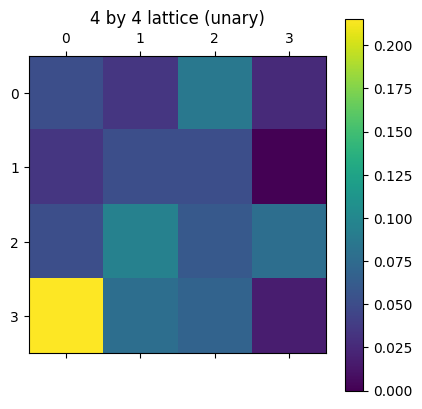

In [61]:
plt.matshow(ionq_freq_normalized[-1,:].reshape(N,N))
plt.title(f"{N} by {N} lattice ({encoding})")
plt.colorbar()
plt.show()

In [52]:
np.savez(join(SAVE_DIR, "data.npz"), 
         ideal_dist=ideal_dist,
         sim_freq=sim_freq,
         ionq_freq=ionq_freq,
         ionq_freq_normalized=ionq_freq_normalized,
         num_samples_subspace_ionq=num_samples_subspace_ionq)

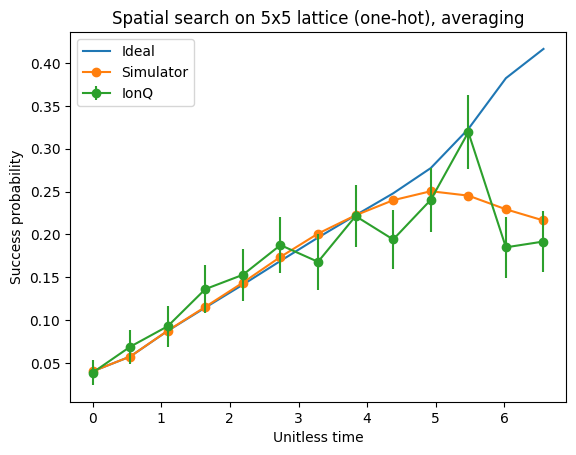

In [53]:

plt.title(f"Spatial search on {N}x{N} lattice ({encoding}), averaging")
plt.plot(np.linspace(0, T, num_time_points_ideal), ideal_success_probability, label="Ideal")
plt.plot(t_vals, success_prob_sim, '-o', label="Simulator")
plt.errorbar(t_vals[valid_points_ionq], success_prob_ionq[valid_points_ionq], err_ionq, fmt='-o', label="IonQ")
plt.ylabel("Success probability")
plt.xlabel("Unitless time")
plt.legend()
plt.show()

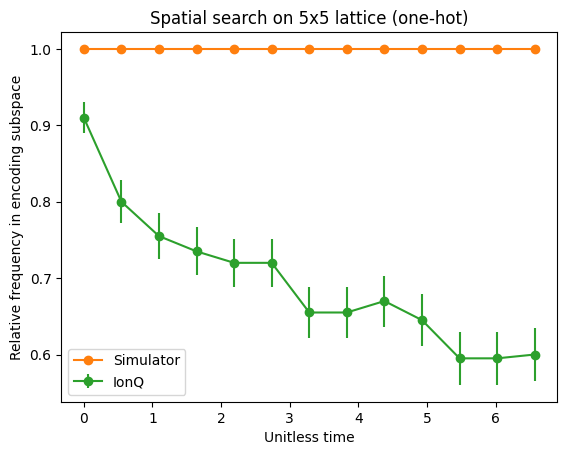

In [54]:
plt.plot(t_vals, np.sum(sim_freq, axis=1), '-o', label="Simulator", color="#ff7f0e")
plt.errorbar(t_vals, np.sum(ionq_freq, axis=1), np.sqrt(np.sum(ionq_freq, axis=1) * (1 - np.sum(ionq_freq, axis=1)) / (num_shots - 1)), fmt='-o', label="IonQ", color="#2ca02c")
plt.xlabel("Unitless time")
plt.ylabel("Relative frequency in encoding subspace")
plt.title(f"Spatial search on {N}x{N} lattice ({encoding})")
plt.legend()
plt.show()

# Fock space method for real space dynamics

In [97]:
DATA_DIR = "experiment_data"
TASK_DIR = "fock_space_method"

CURR_DIR = DATA_DIR
check_and_make_dir(CURR_DIR)
CURR_DIR = join(CURR_DIR, TASK_DIR)
check_and_make_dir(CURR_DIR)

print(CURR_DIR)

use_real_machine = False
if use_real_machine:
    device = "qpu.aria-1"
    print("Device:", device)
else:
    device = LocalSimulator()

    print(f"Using {device.name}")

experiment_data/fock_space_method
Using StateVectorSimulator


In [99]:
N = 5
dimension = 1
encoding = "one-hot"
n = num_qubits_per_dim(N, encoding)
codewords = get_codewords_1d(n, encoding, periodic=False)
bitstrings = get_bitstrings(N, dimension, encoding)

T = 5
r = 11
a = 2
b = -1/2

num_time_points = 21
t_vals = np.linspace(0, T, num_time_points)
num_shots_z = 500
num_shots_x = 1500

use_error_mitigation = True
# Use second-order or use randomized first-order
use_second_order_pf = False

experiment_info = {
    "N": N,
    "dimension": dimension,
    "encoding": encoding,
    "T": T,
    "num_time_points": num_time_points,
    "r": r,
    "a": a,
    "b": b,
    "num_shots_z": num_shots_z,
    "num_shots_x": num_shots_x,
    "use_error_mitigation": use_error_mitigation,
    "use_second_order_pf": use_second_order_pf
}

hash_str = hashlib.md5(json.dumps(experiment_info).encode("utf-8")).hexdigest()
SAVE_DIR = join(CURR_DIR, hash_str)
check_and_make_dir(SAVE_DIR)

print("Save dir:", SAVE_DIR)

with open(join(SAVE_DIR, "experiment_info.json"), "w") as f:
    json.dump(experiment_info, f)
    f.close()

for i in range(num_time_points):
    if not exists(join(SAVE_DIR, f"t_{i}")):
        mkdir(join(SAVE_DIR, f"t_{i}"))

qpu_job_ids_filename_z = 'job_ids_qpu_z.json'
qpu_job_ids_filename_x = 'job_ids_qpu_x.json'

Save dir: experiment_data/fock_space_method/4e2524e8915df206a08691150f789079


Check gate count

In [100]:
instructions = []
# Initial state preparation
instructions.append(get_rx(np.pi, 0))
instructions += get_fock_space_method_circuit(N, a, b, T, r, encoding)

job = get_ionq_job_json("test", N, dimension, num_shots_z, device, encoding, instructions)


In [101]:
# # Create the job json and save it
# job = get_ionq_job_json("test", N, dimension, num_shots_z, "qpu.harmony", encoding, instructions, use_native_gates=True)

# # Send the job and get the job id
# job_id = send_job(job)

Submit tasks

In [102]:
if use_real_machine:
    run_fock_space_method(N, dimension, encoding, num_time_points, t_vals, 
                          TASK_DIR, r, a, b, num_shots_z, num_shots_x, device, SAVE_DIR, 
                          use_real_machine, use_second_order_pf, 
                          qpu_job_ids_filename_z, qpu_job_ids_filename_x)
else:
    sim_prob_z, sim_prob_x = run_fock_space_method(N, dimension, encoding, num_time_points, t_vals, 
                                                   TASK_DIR, r, a, b, num_shots_z, num_shots_x, device, SAVE_DIR, 
                                                   use_real_machine, use_second_order_pf, 
                                                   qpu_job_ids_filename_z, qpu_job_ids_filename_x)

Unitless time:  0.000
1q gates: 1, 2q gates: 0
Unitless time:  0.250
1q gates: 1, 2q gates: 154
Unitless time:  0.500
1q gates: 1, 2q gates: 154
Unitless time:  0.750
1q gates: 1, 2q gates: 154
Unitless time:  1.000
1q gates: 1, 2q gates: 154
Unitless time:  1.250
1q gates: 1, 2q gates: 154
Unitless time:  1.500
1q gates: 1, 2q gates: 154
Unitless time:  1.750
1q gates: 1, 2q gates: 154
Unitless time:  2.000
1q gates: 1, 2q gates: 154
Unitless time:  2.250
1q gates: 1, 2q gates: 154
Unitless time:  2.500
1q gates: 1, 2q gates: 154
Unitless time:  2.750
1q gates: 1, 2q gates: 154
Unitless time:  3.000
1q gates: 1, 2q gates: 154
Unitless time:  3.250
1q gates: 1, 2q gates: 154
Unitless time:  3.500
1q gates: 1, 2q gates: 154
Unitless time:  3.750
1q gates: 1, 2q gates: 154
Unitless time:  4.000
1q gates: 1, 2q gates: 154
Unitless time:  4.250
1q gates: 1, 2q gates: 154
Unitless time:  4.500
1q gates: 1, 2q gates: 154
Unitless time:  4.750
1q gates: 1, 2q gates: 154
Unitless time:  5.000


Get data from completed tasks

In [103]:
def get_results_fock_space_method(N, job_ids_path, use_error_mitigation=False):

    with open(job_ids_path, "r") as f:
        job_ids = json.load(f)
        f.close()

    freq = np.zeros((len(job_ids), 2 ** N))
    for i, job_id in enumerate(job_ids):
        freq[i] = get_ionq_single_job_result(job_id, range(2 ** N), use_error_mitigation)

    return freq

In [104]:
ionq_freq_z = get_results_fock_space_method(N, join(SAVE_DIR, qpu_job_ids_filename_z))
ionq_freq_x = get_results_fock_space_method(N, join(SAVE_DIR, qpu_job_ids_filename_x))

Getting job: 49f8c380-da52-4496-96b2-18bf2cfc144b
Job status: completed
Getting job: 42e57ee4-d16f-4eb2-868e-a164acc9e16f
Job status: completed
Getting job: 4faf87dd-800f-49d5-99eb-e7e5ff88bf2f
Job status: completed
Getting job: 76808a65-89be-42c3-9f15-e725a33ad113
Job status: completed
Getting job: 9bf433b5-6312-45ed-a898-0c29d20f7a6e
Job status: completed
Getting job: 06508dab-36c7-49a5-8260-9a1fc476267a
Job status: completed
Getting job: f2af1b5b-34ab-4f69-8f39-0ca500477fbd
Job status: completed
Getting job: 91decf63-afee-4144-820d-b98358aa2230
Job status: completed
Getting job: ff25181c-b485-4b14-a3b8-fa7d59716a6d
Job status: completed
Getting job: 53fc0575-c0a6-449b-a30f-5ef3d945b6e0
Job status: completed
Getting job: ca7d5bcb-bb45-434f-966e-ec4d400f1872
Job status: completed
Getting job: 576f54c1-ba5b-49fa-a1ec-04b922a389d7
Job status: completed
Getting job: 942f518c-e5b7-486a-a82c-087ccb0ce7ff
Job status: completed
Getting job: bab31a1e-80d9-45d0-9d1f-898075b9fcfa
Job status: co

Post processing and figures

In [105]:
# Observable for each computational basis state
x_obs_vec = np.zeros(2 ** n)
p2_obs_vec_x = np.zeros(2 ** n)
p2_obs_vec_z = np.zeros(2 ** n)

for i in range(2 ** n):
    bitstring = np.binary_repr(i, n)[::-1]

    for j in range(N-1):
        if bitstring[j] == bitstring[j+1]:
            x_obs_vec[i] += np.sqrt((j+1))
        else:
            x_obs_vec[i] -= np.sqrt((j+1))
        
    for j in range(N-2):
        if bitstring[j] == bitstring[j+2]:
            p2_obs_vec_x[i] += np.sqrt((j+1) * (j+2))
        else:
            p2_obs_vec_x[i] -= np.sqrt((j+1) * (j+2))
    
    for j in range(N):
        if bitstring[j] == '1':
            p2_obs_vec_z[i] += (j + 1/2)


x_obs_vec /= np.sqrt(2)
p2_obs_vec_x *= (-0.5)



In [115]:
x_obs_sim = np.zeros(num_time_points)
p2_obs_sim = np.zeros(num_time_points)

x_obs_ionq = np.zeros(num_time_points)
p2_obs_x_ionq = np.zeros(num_time_points)
p2_obs_z_ionq = np.zeros(num_time_points)
pos_observable_ionq = []
for i in range(num_time_points):
    x_obs_sim[i] = x_obs_vec @ sim_prob_x[i]
    x_obs_ionq[i] = x_obs_vec @ ionq_freq_x[i]

    p2_obs_sim[i] = p2_obs_vec_x @ sim_prob_x[i] + (p2_obs_vec_z[codewords] @ sim_prob_z[i][codewords]) / np.sum(sim_prob_z[i][codewords])
    p2_obs_x_ionq[i] = p2_obs_vec_x @ ionq_freq_x[i]
    p2_obs_z_ionq[i] = (p2_obs_vec_z[codewords] @ ionq_freq_z[i][codewords]) / np.sum(ionq_freq_z[i][codewords])

p2_obs_ionq = p2_obs_x_ionq + p2_obs_z_ionq

In [316]:
np.sum(np.array(ionq_freq_z)[:,codewords], axis=1)

array([0.984, 0.884, 0.89 , 0.864, 0.87 , 0.876, 0.892, 0.848, 0.82 ,
       0.856, 0.8  , 0.844, 0.802, 0.774, 0.79 , 0.812, 0.758, 0.736,
       0.768, 0.782, 0.746])

In [317]:
x_obs_ionq_err = np.zeros(num_time_points)
kinetic_energy_err = np.zeros(num_time_points)

for i in range(num_time_points):
    x_obs_ionq_err[i] = np.sqrt(ionq_freq_x[i] @ (x_obs_vec - x_obs_ionq[i]) ** 2 / (num_shots_x - 1))

    # Sqrt of variance of mean for XX observables plus Z observables
    kinetic_energy_err[i] = np.sqrt(0.5 * ionq_freq_x[i] @ (p2_obs_vec_x - p2_obs_x_ionq[i]) ** 2 / (num_shots_x - 1) + \
                                    0.5 * ionq_freq_z[i][codewords] @ (p2_obs_vec_z[codewords] - p2_obs_z_ionq[i]) ** 2 / (num_shots_z - 1))


In [318]:
def get_real_space_hamiltonian(N, a, b):
    p_sq = sum_h_z(N, [-0.5 * (j+1/2) for j in range(N)])
    J = np.zeros((N,N))
    for i in range(N-2):
        J[i, i+2] = -0.5 * np.sqrt((i+1)*(i+2))
    p_sq += (sum_J_xx(N, J) + sum_J_yy(N, J)) / 2

    J = np.zeros((N,N))
    for i in range(N-1):
        J[i, i+1] = np.sqrt((i+1))
    f_linear = b * (1/np.sqrt(2)) * (sum_J_xx(N, J) + sum_J_yy(N, J)) / 2

    J = np.zeros((N,N))
    for i in range(N-2):
        J[i, i+2] = 0.5 * np.sqrt((i+1)*(i+2))

    f_quadratic = 0.5 * a * (sum_h_z(N, [-0.5 * (j+1/2) for j in range(N)]) + (sum_J_xx(N, J) + sum_J_yy(N, J)) / 2)

    H = 0.5 * p_sq + f_linear + f_quadratic
    return H

In [319]:
H_simulator = get_real_space_hamiltonian(N, a, b)
codewords = get_codewords_1d(n, encoding=encoding, periodic=False)

In [320]:
psi_0 = np.zeros(2 ** N)
psi_0[codewords[0]] = 1

# Position observable
J = np.zeros((N,N))
for i in range(N-1):
    J[i, i+1] = np.sqrt((i+1))
x_hat = (1/np.sqrt(2)) * sum_J_xx(N, J)

x_sq = sum_delta_n(N, [(j+1/2) for j in range(N)])
J = np.zeros((N,N))
for i in range(N-2):
    J[i, i+2] = 0.5 * np.sqrt((i+1)*(i+2))
x_sq += sum_J_xx(N, J)

p_sq = sum_delta_n(N, [(j+1/2) for j in range(N)])
J = np.zeros((N,N))
for i in range(N-2):
    J[i, i+2] = -0.5 * np.sqrt((i+1)*(i+2))
p_sq += sum_J_xx(N, J)

num_time_points_ideal = num_time_points
psi = expm_multiply(-1j * H_simulator, psi_0, start=0, stop=T, num=num_time_points_ideal)

In [321]:
x_obs_ham_ebd = np.zeros(num_time_points_ideal)
x2_obs_ham_ebd = np.zeros(num_time_points_ideal)
p2_obs_ham_ebd = np.zeros(num_time_points_ideal)

for i in range(num_time_points_ideal):
    x_obs_ham_ebd[i] = (np.conj(psi[i]) @ x_hat @ psi[i]).real
    x2_obs_ham_ebd[i] = (np.conj(psi[i]) @ x_sq @ psi[i]).real
    p2_obs_ham_ebd[i] = (np.conj(psi[i]) @ p_sq @ psi[i]).real

kinetic_energy_ham_ebd = 0.5 * p2_obs_ham_ebd
potential_energy_ham_ebd = 0.5 * a * x2_obs_ham_ebd + b * x_obs_ham_ebd

In [322]:
# Analytical solution
expected_position_analytical = (b / a) * (np.cos(np.sqrt(a) * t_vals) - 1)

In [323]:
# data = np.load(join(SAVE_DIR, "data.npz"))
# expected_position_analytical = data["expected_position_analytical"]
# ionq_freq_z = data["ionq_freq_z"]           # Relative frequency in z basis (all 2^5 states; 3000 shots total for each time point)
# ionq_freq_x = data["ionq_freq_x"]           # Relative frequency in x basis (all 2^5 states; 3000 shots total for each time point)
# x_obs_ham_ebd = data["x_obs_ham_ebd"]       # <\hat{x}> for Hamiltonian embedding
# x_obs_sim = data["x_obs_sim"]               # <\hat{x}> for circuit simulator
# x_obs_ionq = data["x_obs_ionq"]             # <\hat{x}> for IonQ
# x_obs_ionq_err = data["x_obs_ionq_err"]     # Standard error for <\hat{x}>; refer to notebook for calculation
# p2_obs_ham_ebd = data["p2_obs_ham_ebd"]     # <\hat{p}^2> for Hamiltonian embedding
# p2_obs_sim = data["p2_obs_sim"]             # <\hat{p}^2> for circuit simulator
# p2_obs_ionq = data["p2_obs_ionq"]
# kinetic_energy_err = data["kinetic_energy_err"]

In [324]:
# np.savez(join(SAVE_DIR, "data.npz"), 
#          expected_position_analytical=expected_position_analytical,
#          ionq_freq_z=ionq_freq_z,               # Relative frequency in z basis (all 2^5 states; 3000 shots total for each time point)
#          ionq_freq_x=ionq_freq_x,               # Relative frequency in x basis (all 2^5 states; 3000 shots total for each time point)
#          x_obs_ham_ebd=x_obs_ham_ebd,           # <\hat{x}> for Hamiltonian embedding
#          x_obs_sim=x_obs_sim,                   # <\hat{x}> for circuit simulator
#          x_obs_ionq=x_obs_ionq,                 # <\hat{x}> for IonQ
#          x_obs_ionq_err=x_obs_ionq_err,         # Standard error for <\hat{x}>; refer to notebook for calculation
#          p2_obs_ham_ebd=p2_obs_ham_ebd,         # <\hat{p}^2> for Hamiltonian embedding
#          p2_obs_sim=p2_obs_sim,                 # <\hat{p}^2> for circuit simulator
#          p2_obs_ionq=p2_obs_ionq,               # <\hat{p}^2> for IonQ
#          kinetic_energy_err=kinetic_energy_err) # std error for kinetic energy

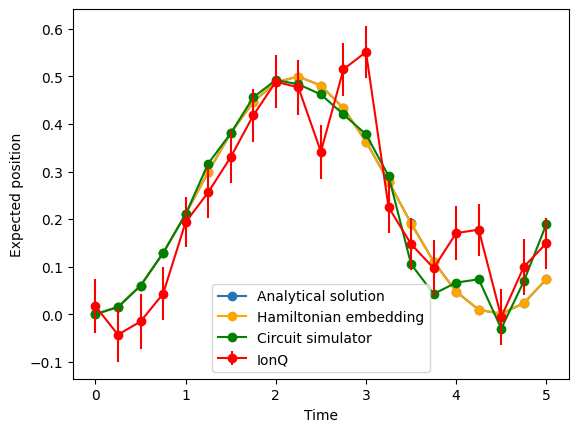

In [325]:
plt.plot(np.linspace(0, T, num_time_points_ideal), expected_position_analytical, '-o', label="Analytical solution")
plt.plot(np.linspace(0, T, num_time_points_ideal), x_obs_ham_ebd, '-o', color="orange", label="Hamiltonian embedding")
plt.plot(t_vals, x_obs_sim, '-o', color="green", label="Circuit simulator")
plt.errorbar(t_vals, x_obs_ionq, x_obs_ionq_err, color="red", fmt='-o', label="IonQ")
plt.ylabel("Expected position")
plt.xlabel("Time")
plt.legend()
plt.show()

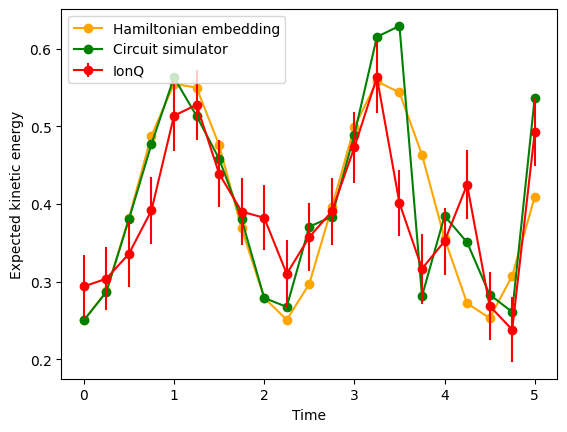

In [326]:
plt.plot(np.linspace(0, T, num_time_points_ideal), 0.5 * p2_obs_ham_ebd, '-o', color='orange', label="Hamiltonian embedding")
plt.plot(t_vals, 0.5 * p2_obs_sim, '-o', color='green', label="Circuit simulator")
plt.errorbar(t_vals, 0.5 * p2_obs_ionq, kinetic_energy_err, fmt='-o', color='red', label="IonQ")
plt.ylabel("Expected kinetic energy")
plt.xlabel("Time")
plt.legend()
plt.show()